# 1) Introduction

### Business Objectives
This company is the largest online loan marketplace facilitating personal loans, business loans, and the financing of medical procedures. Borrowers can easily access lower interest rate loans through a fast online interface.

Like most other lending companies, lending to ‘risky’ applicants is the largest source of financial loss (called credit loss). Credit loss is the amount of money lost by the lender when the borrower refuses to pay or absconds with the money owed. In other words, borrowers who default cause the biggest losses to lenders. In this case, customers labelled as ‘charged-off’ are the ‘defaulters’.

 

If one is able to identify these risky loan applicants, then such loans can be reduced, thereby cutting down the amount of credit loss. Identification of such applicants using EDA is the aim of this case study.

 

In other words, the company wants to understand the driving factors (or driver variables) behind loan default, i.e., the variables which are strong indicators of default. The company can utilise this knowledge for its portfolio and risk assessment. 


To develop your understanding of the domain, you are advised to independently research a little about risk analytics (understanding the types of variables and their significance should be enough).

# 2) Import the Data

In [1]:
# Package Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import pearsonr
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set()

##### Read the Data into a pandas Dataframe

In [2]:
loans = pd.read_csv("loan.csv")

##### Check basic dataframe info:

In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


##### There are 39 thousand rows and 111 variables. The size of the dataset is 33 MB. Let's peek at 5 randomly selected rows. Each row corresponds to a single loan.

In [4]:
loans.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
13792,775782,978057,8000,8000,8000.0,36 months,5.99%,243.34,A,A2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
17911,701983,893821,20000,20000,20000.0,60 months,13.06%,455.68,C,C2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2129,1031022,1260445,18725,18725,18450.0,60 months,17.27%,468.09,D,D3,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
16636,729142,924897,4800,4800,4800.0,60 months,16.77%,118.70,E,E2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
18997,677834,865994,12000,12000,11975.0,60 months,18.25%,306.36,F,F1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


# 3) Response Variable
##### We're going to try to find the driving features that helps the company to predict loan_status variable. Let's see what are the value counts for this variable

In [5]:
loans["loan_status"].value_counts(dropna=False)

loan_status
Fully Paid     32950
Charged Off     5627
Current         1140
Name: count, dtype: int64

##### We're going to try to learn differences in the features between completed loans that have been fully paid or charged off. We won't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. So we only keep the loans with status "Fully Paid" or "Charged Off."

In [6]:
loans = loans[loans["loan_status"].isin(values=["Fully Paid", "Charged Off"])]

##### Let's Check the shape of the dataframe now

In [7]:
loans.shape

(38577, 111)

##### Just to be sure let's check the value_counts of 'loan_status' variable

In [8]:
loans['loan_status'].value_counts(dropna=False)

loan_status
Fully Paid     32950
Charged Off     5627
Name: count, dtype: int64

##### Status counts as percentage

In [9]:
loans["loan_status"].value_counts(dropna=False, normalize=True) * 100

loan_status
Fully Paid     85.413588
Charged Off    14.586412
Name: proportion, dtype: float64

##### About 85% of the remaining loans have been fully paid and 14% have charged off, so we have a somewhat unbalanced classification problem.

# 4) Limit the feature space
##### The full dataset has 150 features for each loan. We'll select features in two steps:

##### 1) Drop features with more than 30% of their data missing.
##### 2) Of the remaining features, choose only those that would be available to an investor before deciding to fund the loan.
##### Definitions of the features are given in the LendingClub Data Dictionary available here.

#### 4.1) Drop features missing more than 30% - 40% data
##### first let's calculate the percentage of missing data for each feature

In [10]:
missing = loans.isnull().mean().sort_values(ascending=False) * 100

In [14]:
loans.dropna

(38577, 111)

##### Top 10 features missing the most data

In [75]:
missing.head(10)

verification_status_joint    100.0
annual_inc_joint             100.0
mo_sin_old_rev_tl_op         100.0
mo_sin_old_il_acct           100.0
bc_util                      100.0
bc_open_to_buy               100.0
avg_cur_bal                  100.0
acc_open_past_24mths         100.0
inq_last_12m                 100.0
total_cu_tl                  100.0
dtype: float64

##### Let's make a list of all the features that we need to drop by the condition that they have more than 30% of their values missing.

In [76]:
drop_list = sorted(list(missing[missing > 30].index))
drop_list

['acc_open_past_24mths',
 'all_util',
 'annual_inc_joint',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'desc',
 'dti_joint',
 'il_util',
 'inq_fi',
 'inq_last_12m',
 'max_bal_bc',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'next_pymnt_d',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'open_acc_6m',
 'open_il_12m',
 'open_il_24m',
 'open_il_6m',
 'open_rv_12m',
 'open_rv_24m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'tot_coll_amt',
 'tot_cur_bal',
 'tot_hi_cred_lim',
 'total_bal_ex_

In [77]:
len(drop_list)

58

##### Hence, let's drop these 58 Features

In [78]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [79]:
loans.shape

(38577, 53)

#### 4.2) Only keep loan features known to potential investors
##### We will examine the LendingClub's website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features we currently have, in alphabetical order:

In [80]:
print(sorted(loans.columns))

['acc_now_delinq', 'addr_state', 'annual_inc', 'application_type', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'funded_amnt', 'funded_amnt_inv', 'grade', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'member_id', 'open_acc', 'out_prncp', 'out_prncp_inv', 'policy_code', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'pymnt_plan', 'recoveries', 'revol_bal', 'revol_util', 'sub_grade', 'tax_liens', 'term', 'title', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'url', 'verification_status', 'zip_code']


##### For each of these features, we check the description in the Data Dictionary and only keep the features that would have been available to investors considering an investment in the loan. These include features in the loan application, and any features added by LendingClub when the loan listing was accepted, such as the loan grade and interest rate.

##### I'm using my best available knowledge to determine which loan features are known to potential investors. I am not an investor on LendingClub, so my knowledge of the LendingClub investment process is not exact. When in doubt, I err on the side of dropping the feature.

In [81]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

In [82]:
len(keep_list)

31

##### Let's drop all the columns that are NOT in the keep_list

In [83]:
drop_list_2 = [col for col in loans.columns if col not in keep_list]
print(sorted(drop_list_2))

['acc_now_delinq', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'funded_amnt', 'funded_amnt_inv', 'inq_last_6mths', 'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d', 'member_id', 'out_prncp', 'out_prncp_inv', 'policy_code', 'pymnt_plan', 'recoveries', 'tax_liens', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'url']


In [84]:
len(drop_list_2)

25

##### Let's drop these features

In [85]:
loans.drop(labels=drop_list_2, axis=1, inplace=True)

In [86]:
loans.shape

(38577, 28)

##### Printing the remaining column names for future reference

In [87]:
print(list(loans.columns))

['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'pub_rec_bankruptcies']


#### 4.3) Now let's handle the remaining NaN values 
Printing the percentage null values in each of the columns 

In [88]:
loans.isnull().sum() * 100 / len(loans)

id                      0.000000
loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               6.185033
emp_length              2.677761
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.028514
zip_code                0.000000
addr_state              0.000000
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.129611
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
pub_rec_bankruptcies    1.806776
dtype: float64

##### We need to handle emp_title, emp_length, revol_util, and pub_rec_bankruptcies columns. Let's see the rows which have NaN values

In [89]:
loans[loans.isnull().sum(axis=1) > 0].shape

(3150, 28)

Hence, there are 3000+ rows that contain NaN values, Rows can be deleted as the number of missing values is insignificant, as this would not impact the overall analysis results. Hence, Deleting the rows that contain nan

In [90]:
loans = loans[~(loans.isnull().sum(axis=1) > 0)]

##### Just to be sure, let's check the shape of the loans dataframe

In [91]:
loans.shape

(35427, 28)

So, The rows were deleted

# 5) Pre-processing and Exploratory Analysis
##### We'll inspect each feature individually, and do the following:

1) Drop the feature if it is not useful as a driving variable.
2) View summary statistics and visualize the data, plotting against the loan status.
3) Modify the feature to make it useful for modeling, if necessary.

#### 5.1) id
##### Data Dictionary: "A unique LC(Lending Club) assigned ID for the loan listing."

In [92]:
loans["id"].sample(5)

24612    598126
3444     909295
30219    511908
25024    591503
28209    531759
Name: id, dtype: int64

##### Let's see if all the id's unique.

In [93]:
loans["id"].unique()

array([1077430, 1076863, 1075269, ...,  132892,  119043,  112496])

##### Yes, they are all unique. The ID is not useful as the driving factors, either as a categorical variable (there are too many distinct values) or as a numerical variable (the IDs vary wildly in magnitude, likely without any significance), so we drop this variable.

In [94]:
loans.drop('id', axis=1, inplace=True)

#### 5.2) loan_amnt
##### Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [95]:
loans["loan_amnt"].describe()

count    35427.000000
mean     11128.966607
std       7327.746599
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

Loan amount ranges from 500 dollars to 35,000 dollars with a median of 9,600 dollars

##### Now, let's plot a histogram and box plot of the loan_amnt and loan_status feature

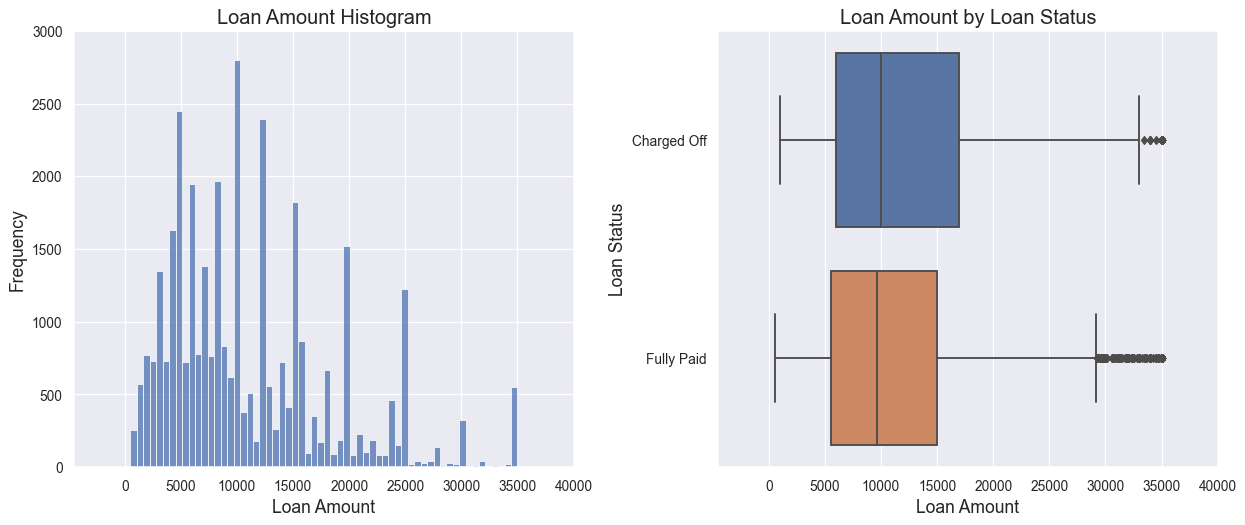

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=90)
ax1.margins(0)
ax2.margins(0)

sns.histplot(data=loans, x="loan_amnt", ax=ax1) 
ax1.set_xlabel("Loan Amount", fontsize=14)
ax1.set_title("Loan Amount Histogram", fontsize=16)
ax1.set_ylabel("Frequency", fontsize=14)
ax1.set_xlim([min(loans["loan_amnt"]) - 5000, max(loans["loan_amnt"]) + 5000])
ax1.set_ylim(0, 3000)

sns.boxplot(data=loans, x="loan_amnt", y="loan_status", ax=ax2)
ax2.set_title("Loan Amount by Loan Status", fontsize=16)
ax2.set_xlabel("Loan Amount", fontsize=14)
ax2.set_ylabel("Loan Status", fontsize=14)
ax2.set_xlim([min(loans["loan_amnt"]) - 5000, max(loans["loan_amnt"]) + 5000])

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

plt.show()

##### Charged-off loans tend to have slighly higher loan amounts. Let's Confirm that with a reggression plot

In [262]:
charged_off_loan_amount = loans.groupby("loan_amnt")["loan_status"].value_counts(normalize=True)[:, "Charged Off"]
loan_amnt_coeff, _ = pearsonr(charged_off_loan_amount.index, charged_off_loan_amount.values)

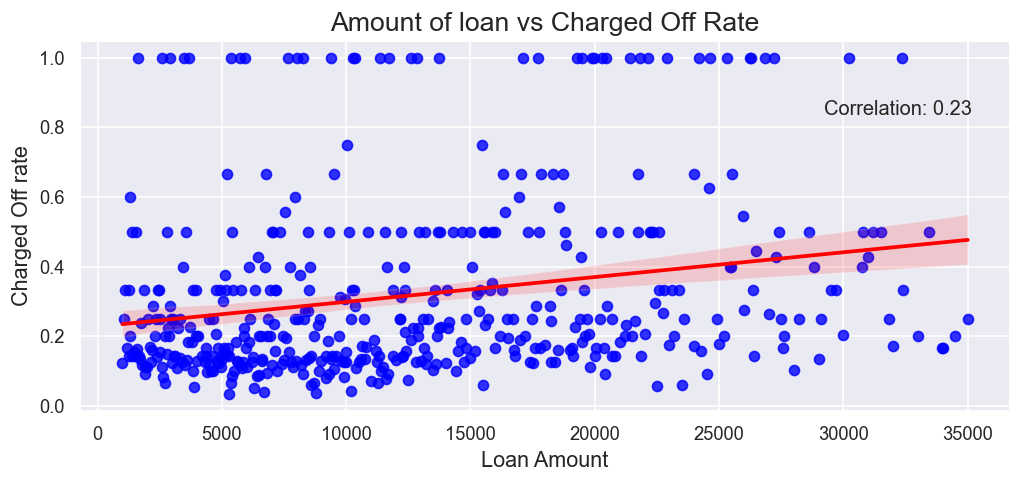

In [264]:
plt.figure(figsize=(10,4), dpi=120)
sns.regplot(x=charged_off_loan_amount.index, y=charged_off_loan_amount.values, line_kws={"color": "red"}, scatter_kws={"color": "blue"})
plt.title("Amount of loan vs Charged Off Rate", fontsize=16)
plt.xlabel("Loan Amount", fontsize=13)
plt.ylabel("Charged Off rate", fontsize=13)
plt.text(0.8, 0.8, f"Correlation: {loan_amnt_coeff:.2f}", transform=plt.gca().transAxes, fontsize=12)
plt.show()

 We see that there is a weak positive relation as the amount of loan increases the Charged-Off rate also increase. Let's compare the summary statistics by loan status.

In [97]:
loans.groupby(by="loan_status")["loan_amnt"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5003.0,12243.249051,8070.584523,1000.0,6000.0,10000.0,16950.0,35000.0
Fully Paid,30424.0,10945.731166,7181.867451,500.0,5500.0,9600.0,15000.0,35000.0


#### 5.3) Term
##### Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

In [98]:
loans["term"].value_counts()

term
 36 months    26422
 60 months     9005
Name: count, dtype: int64

Converting Term to an INT

In [99]:
loans["term"] = loans["term"].apply(func=lambda x: int(x.split()[0]))

In [100]:
loans["term"].value_counts()

term
36    26422
60     9005
Name: count, dtype: int64

##### Comparing the charge off rate by loan period

In [265]:
charged_off_term = loans.groupby(by="term")["loan_status"].value_counts(normalize=True)[:, "Charged Off"]
charged_off_term

term
36    0.105026
60    0.247418
Name: proportion, dtype: float64

Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods. Let's Plot That using a bar plot

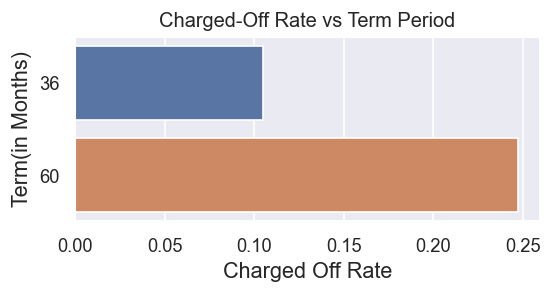

In [268]:
plt.figure(figsize=(5,2), dpi=120)
sns.barplot(x=charged_off_term.values, y=charged_off_term.index, orient="h")
plt.xlabel("Charged Off Rate", fontsize=13)
plt.ylabel("Term(in Months)", fontsize=13)
plt.title("Charged-Off Rate vs Term Period")
plt.show()

# 5.4) int_rate
##### Data Dictionary: "Interest Rate on the loan."

In [102]:
loans["int_rate"].describe()

count      35427
unique       334
top       10.99%
freq         862
Name: int_rate, dtype: object

Changing the data type of int_rate column to a float

In [103]:
loans["int_rate"] = loans["int_rate"].apply(func=lambda x: float(x.replace("%", "")))

In [104]:
loans["int_rate"].describe()

count    35427.000000
mean        11.986776
std          3.702690
min          5.420000
25%          8.940000
50%         11.860000
75%         14.500000
max         24.400000
Name: int_rate, dtype: float64

##### Interest rates ranges from 5.42% to 24.40% with a median of 11.86%
##### Plotting a histogram of int_rate and a box plot of int_rate and loan_status

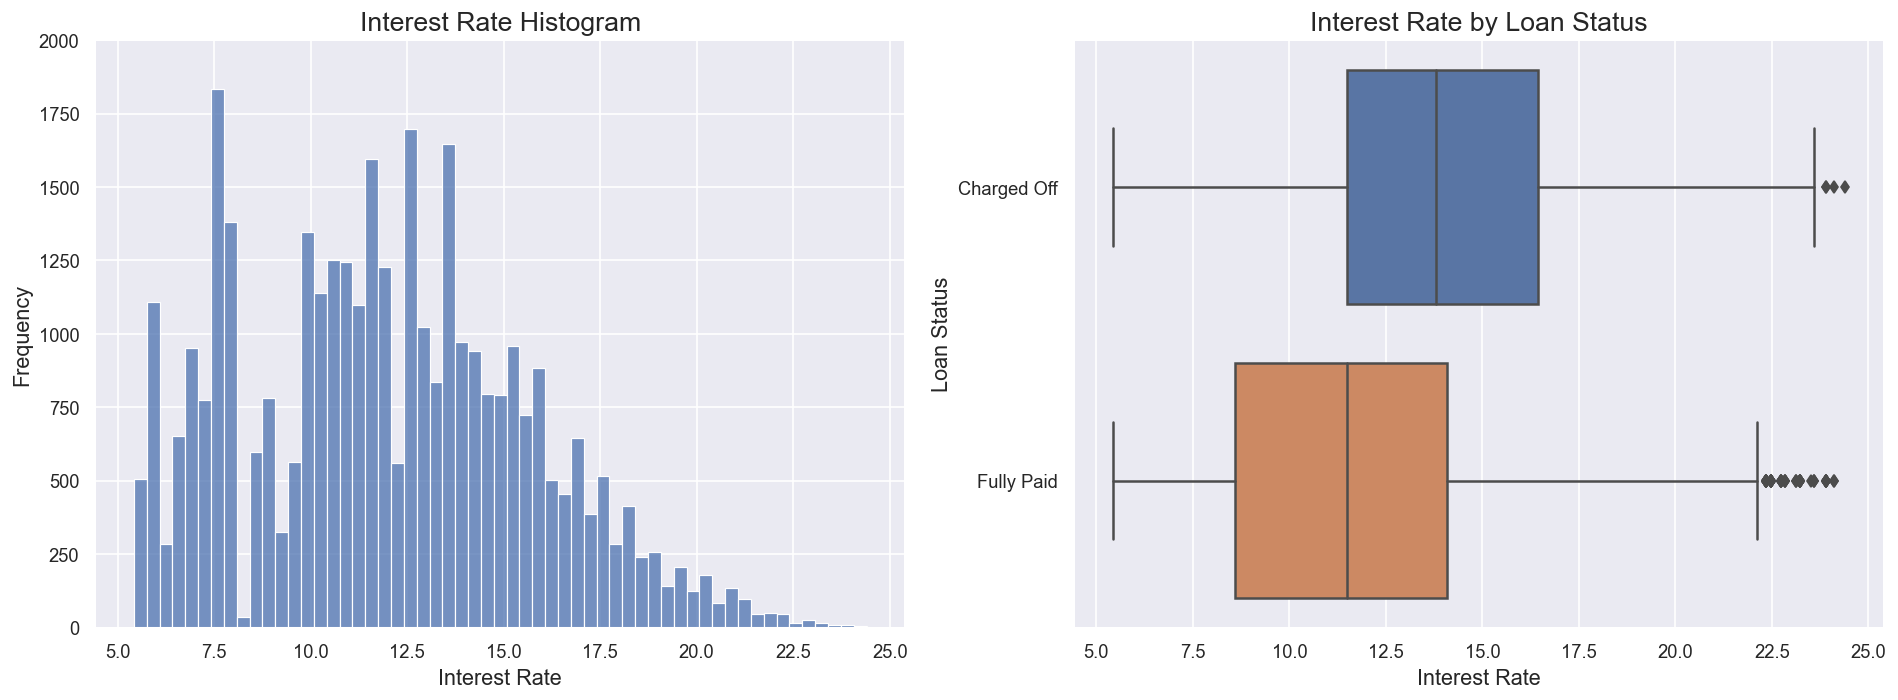

In [105]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), dpi=120)
ax1.margins(0)
ax2.margins(0)

sns.histplot(data=loans, x="int_rate", ax=ax1)
ax1.set_title("Interest Rate Histogram", fontsize=16)
ax1.set_xlabel("Interest Rate", fontsize=13)
ax1.set_ylabel("Frequency", fontsize=13)
ax1.set_xlim(min(loans["int_rate"]) - 1, max(loans["int_rate"]) + 1)
ax1.set_ylim(0, 2000)

sns.boxplot(data=loans, x="int_rate", y="loan_status", ax=ax2)
ax2.set_title("Interest Rate by Loan Status", fontsize=16)
ax2.set_xlabel("Interest Rate", fontsize=13)
ax2.set_ylabel("Loan Status", fontsize=13)
ax2.set_xlim(min(loans["int_rate"]) - 1, max(loans["int_rate"]) + 1)

plt.tight_layout()
plt.show()

Charged-off loans tend to have much higher interest rates. Let's plot it on a regression plot

In [281]:
charged_off_int_rate = loans.groupby(by="int_rate")["loan_status"].value_counts(normalize=True)[:, "Charged Off"]
int_rate_coeff, _ = pearsonr(charged_off_int_rate.index, charged_off_int_rate.values)
charged_off_int_rate

int_rate
5.42     0.025743
5.79     0.034211
5.99     0.057325
6.03     0.012531
6.17     0.030303
           ...   
23.52    0.800000
23.59    0.250000
23.91    0.222222
24.11    0.333333
24.40    1.000000
Name: proportion, Length: 291, dtype: float64

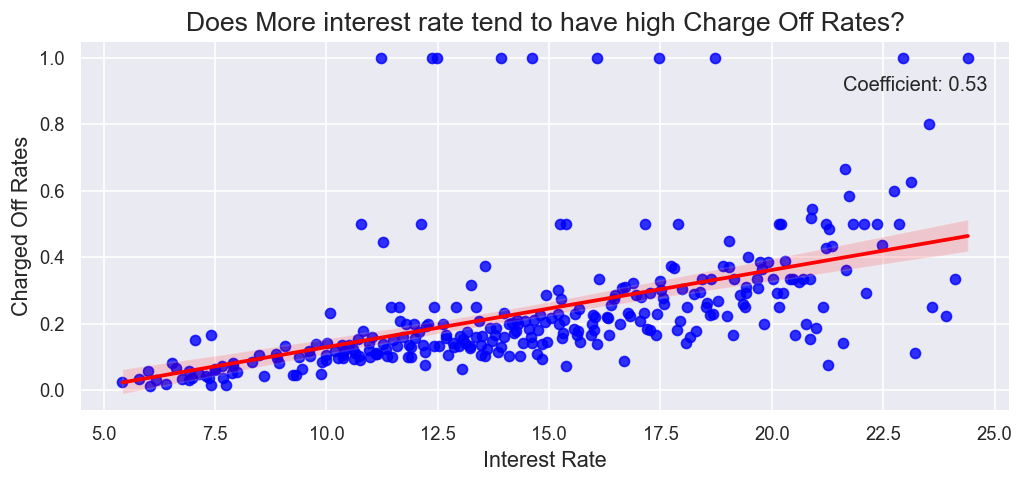

In [291]:
plt.figure(figsize=(10, 4), dpi=120)
sns.regplot(x=charged_off_int_rate.index, y=charged_off_int_rate.values, line_kws={"color": "red"}, scatter_kws={"color": "blue"})
plt.title("Does More interest rate tend to have high Charge Off Rates?", fontsize=16)
plt.xlabel("Interest Rate", fontsize=13)
plt.ylabel("Charged Off Rates", fontsize=13)
plt.text(0.82, 0.865, f"Coefficient: {int_rate_coeff:.2f}", transform=plt.gca().transAxes, fontsize=12)
plt.show()

That confirms it. Now let's compare the summary statistics by loan status:

In [106]:
loans.groupby(by="loan_status")["int_rate"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5003.0,13.929906,3.643300,5.42,11.49,13.79,16.45,24.40
Fully Paid,30424.0,11.667243,3.613734,5.42,8.59,11.49,14.09,24.11


# 5.5) Installment
##### Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [107]:
loans["installment"].describe()

count    35427.000000
mean       323.944720
std        207.196234
min         16.080000
25%        167.740000
50%        280.280000
75%        426.480000
max       1305.190000
Name: installment, dtype: float64

We see that the installments range from 16 dollars to 1305 dollars with 280 dollars as median

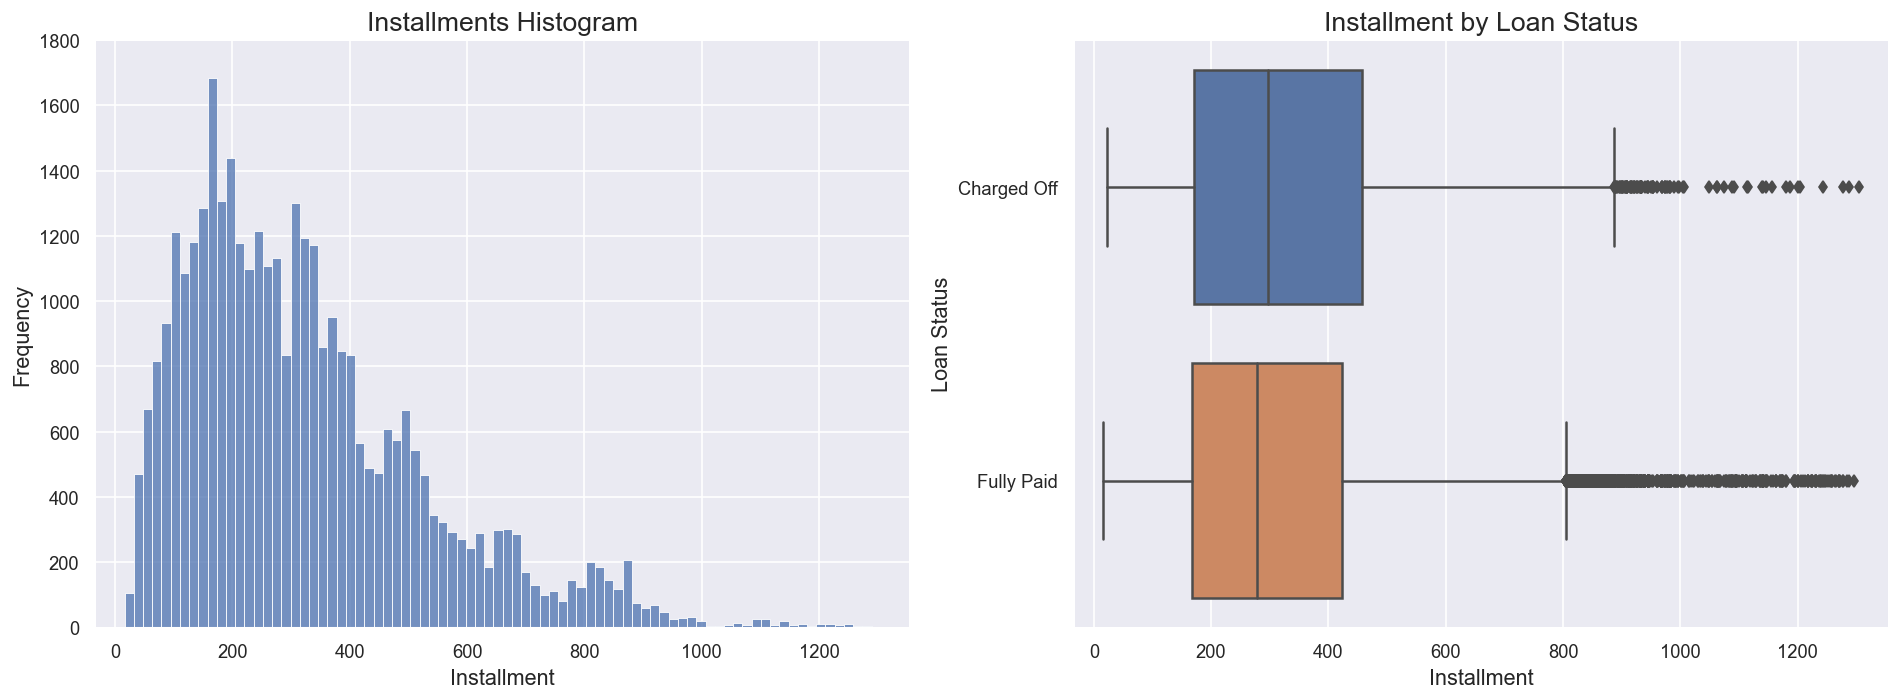

In [108]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), dpi=120)
ax1.margins(0)
ax2.margins(0)

sns.histplot(data=loans, x="installment", ax=ax1)
ax1.set_title("Installments Histogram", fontsize=16)
ax1.set_xlabel("Installment", fontsize=13)
ax1.set_ylabel("Frequency", fontsize=13)
ax1.set_xlim(min(loans["installment"]) - 50, max(loans["installment"]) + 50)
ax1.set_ylim(0, 1800)

sns.boxplot(data=loans, x="installment", y="loan_status", ax=ax2)
ax2.set_title("Installment by Loan Status", fontsize=16)
ax2.set_xlabel("Installment", fontsize=13)
ax2.set_ylabel("Loan Status", fontsize=13)
ax2.set_xlim(min(loans["installment"]) - 50, max(loans["installment"]) + 50)

plt.tight_layout()
plt.show()

##### Charge - Off loans tend to have higher installments. Let's plot its regression plot

In [292]:
charged_off_install = loans.groupby(by="installment")["loan_status"].value_counts(normalize=True)[:, "Charged Off"]
installment_coeff, _ = pearsonr(charged_off_install.index, charged_off_install.values)
charged_off_install

installment
22.79      1.000000
24.16      1.000000
24.32      1.000000
28.92      1.000000
29.44      1.000000
             ...   
1203.66    1.000000
1243.85    0.333333
1276.60    0.333333
1288.10    0.500000
1305.19    1.000000
Name: proportion, Length: 3897, dtype: float64

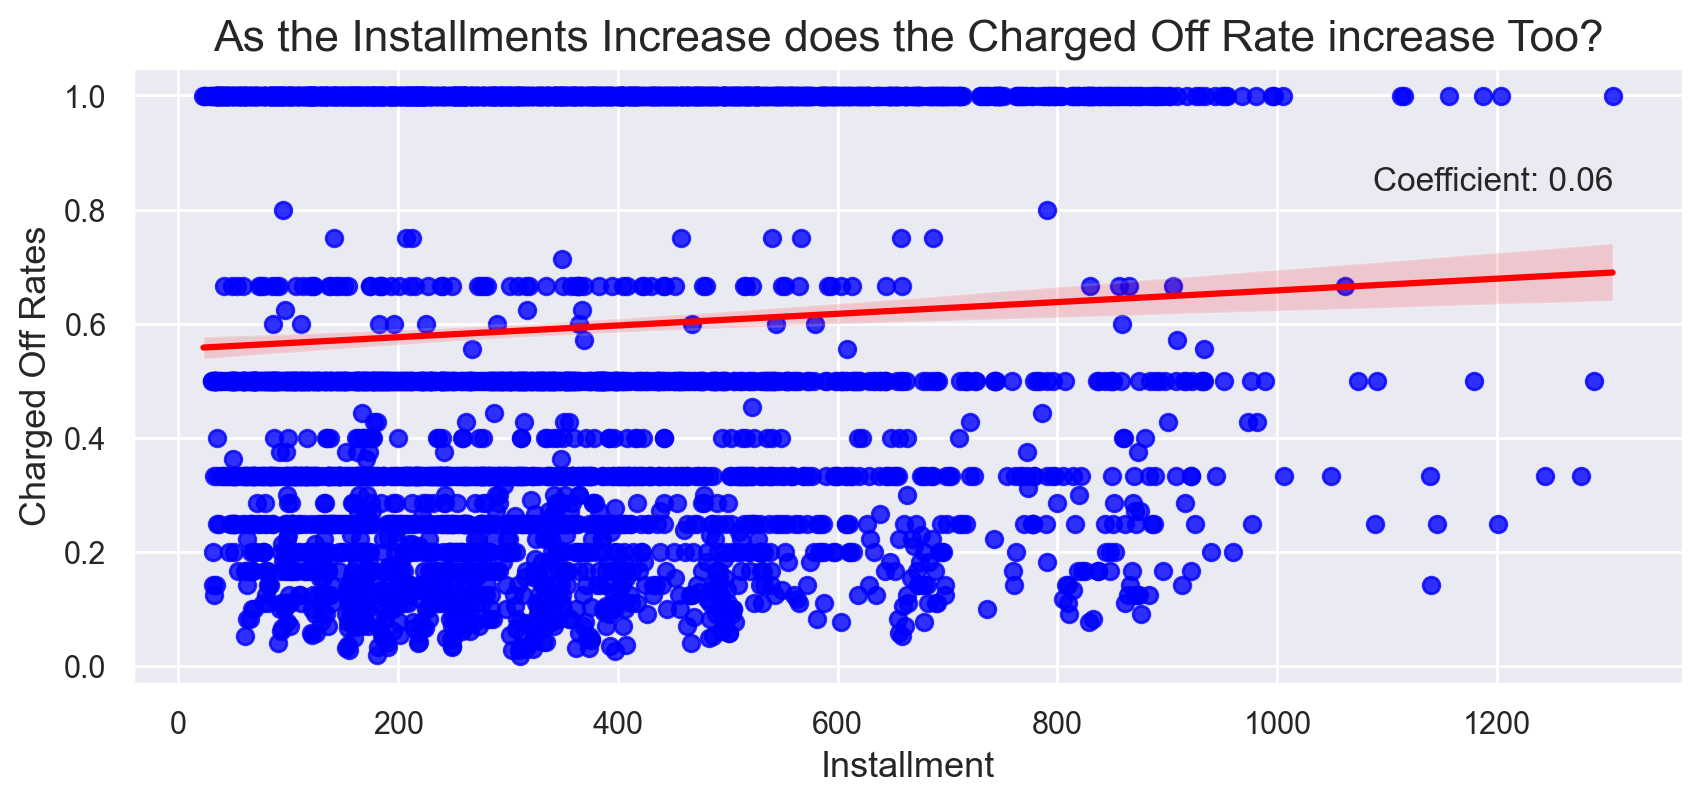

In [391]:
plt.figure(figsize=(10,4), dpi=200)
sns.regplot(x=charged_off_install.index, y=charged_off_install.values, line_kws={"color": "red"}, scatter_kws={"color": "blue"})
plt.xlabel("Installment", fontsize=13)
plt.ylabel("Charged Off Rates", fontsize=13)
plt.title("As the Installments Increase does the Charged Off Rate increase Too?", fontsize=16)
plt.text(0.8, 0.8, f"Coefficient: {installment_coeff:.2f}", transform=plt.gca().transAxes, fontsize=12)
plt.show()

Very Slightly. Now let's compare the summary statistics by loan status:

In [109]:
loans.groupby(by="loan_status")["installment"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5003.0,337.968019,214.815931,22.79,171.5500,297.53,457.5950,1305.19
Fully Paid,30424.0,321.638693,205.828423,16.08,167.2975,278.24,422.3075,1295.21


Loans that charge off have $16 higher installments on average.

#### 5.6) grade, sub_grade
##### Data Dictionary for grade: "LendingClub assigned loan grade."

##### Data Dictionary for sub_grade: "LendingClub assigned loan subgrade."
##### Let's see the possible values of grade and sub_grade

In [110]:
sorted(loans["grade"].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [111]:
print(sorted(loans["sub_grade"].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The grade is implied by the subgrade, so let's drop the grade column.

In [112]:
loans.drop(labels="grade", axis=1, inplace=True)

In [113]:
charge_off_rates = loans.groupby("sub_grade")['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
charge_off_rates

sub_grade
A1    0.022886
A2    0.047163
A3    0.049663
A4    0.059354
A5    0.077479
B1    0.088545
B2    0.105148
B3    0.118919
B4    0.128273
B5    0.136141
C1    0.154584
C2    0.160267
C3    0.176000
C4    0.169399
C5    0.174408
D1    0.169611
D2    0.201348
D3    0.223633
D4    0.229142
D5    0.243137
E1    0.267728
E2    0.264912
E3    0.221074
E4    0.293671
E5    0.275862
F1    0.286689
F2    0.294393
F3    0.281250
F4    0.352941
F5    0.464646
G1    0.311111
G2    0.364865
G3    0.439024
G4    0.240741
G5    0.360000
Name: proportion, dtype: float64

Let's plot a histogram of sub_grade

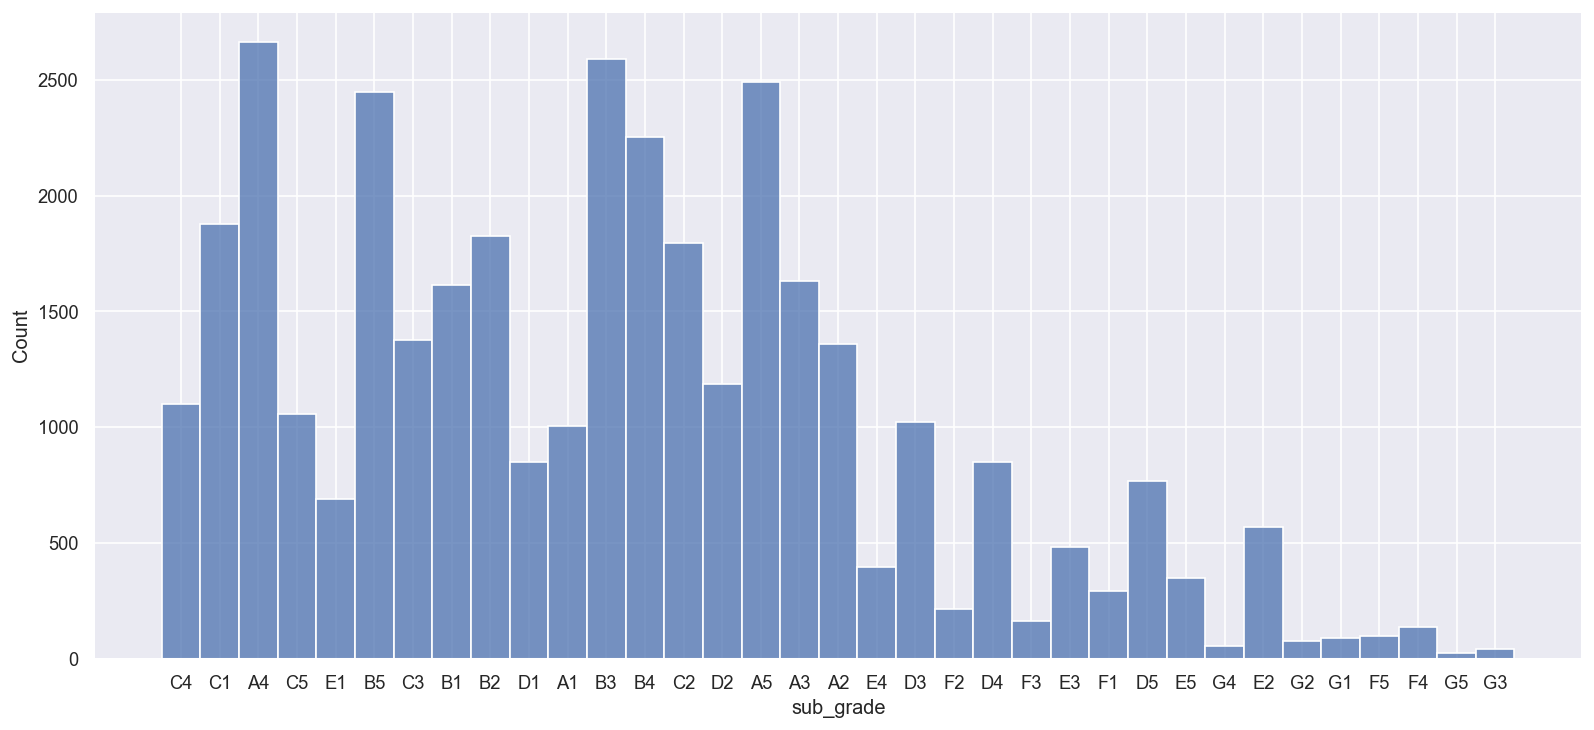

In [114]:
plt.figure(figsize=(16, 7), dpi=120)
sns.histplot(data=loans, x="sub_grade")
plt.show()

Now a Bar Plot between Sub Grade and Charged-Off Rate

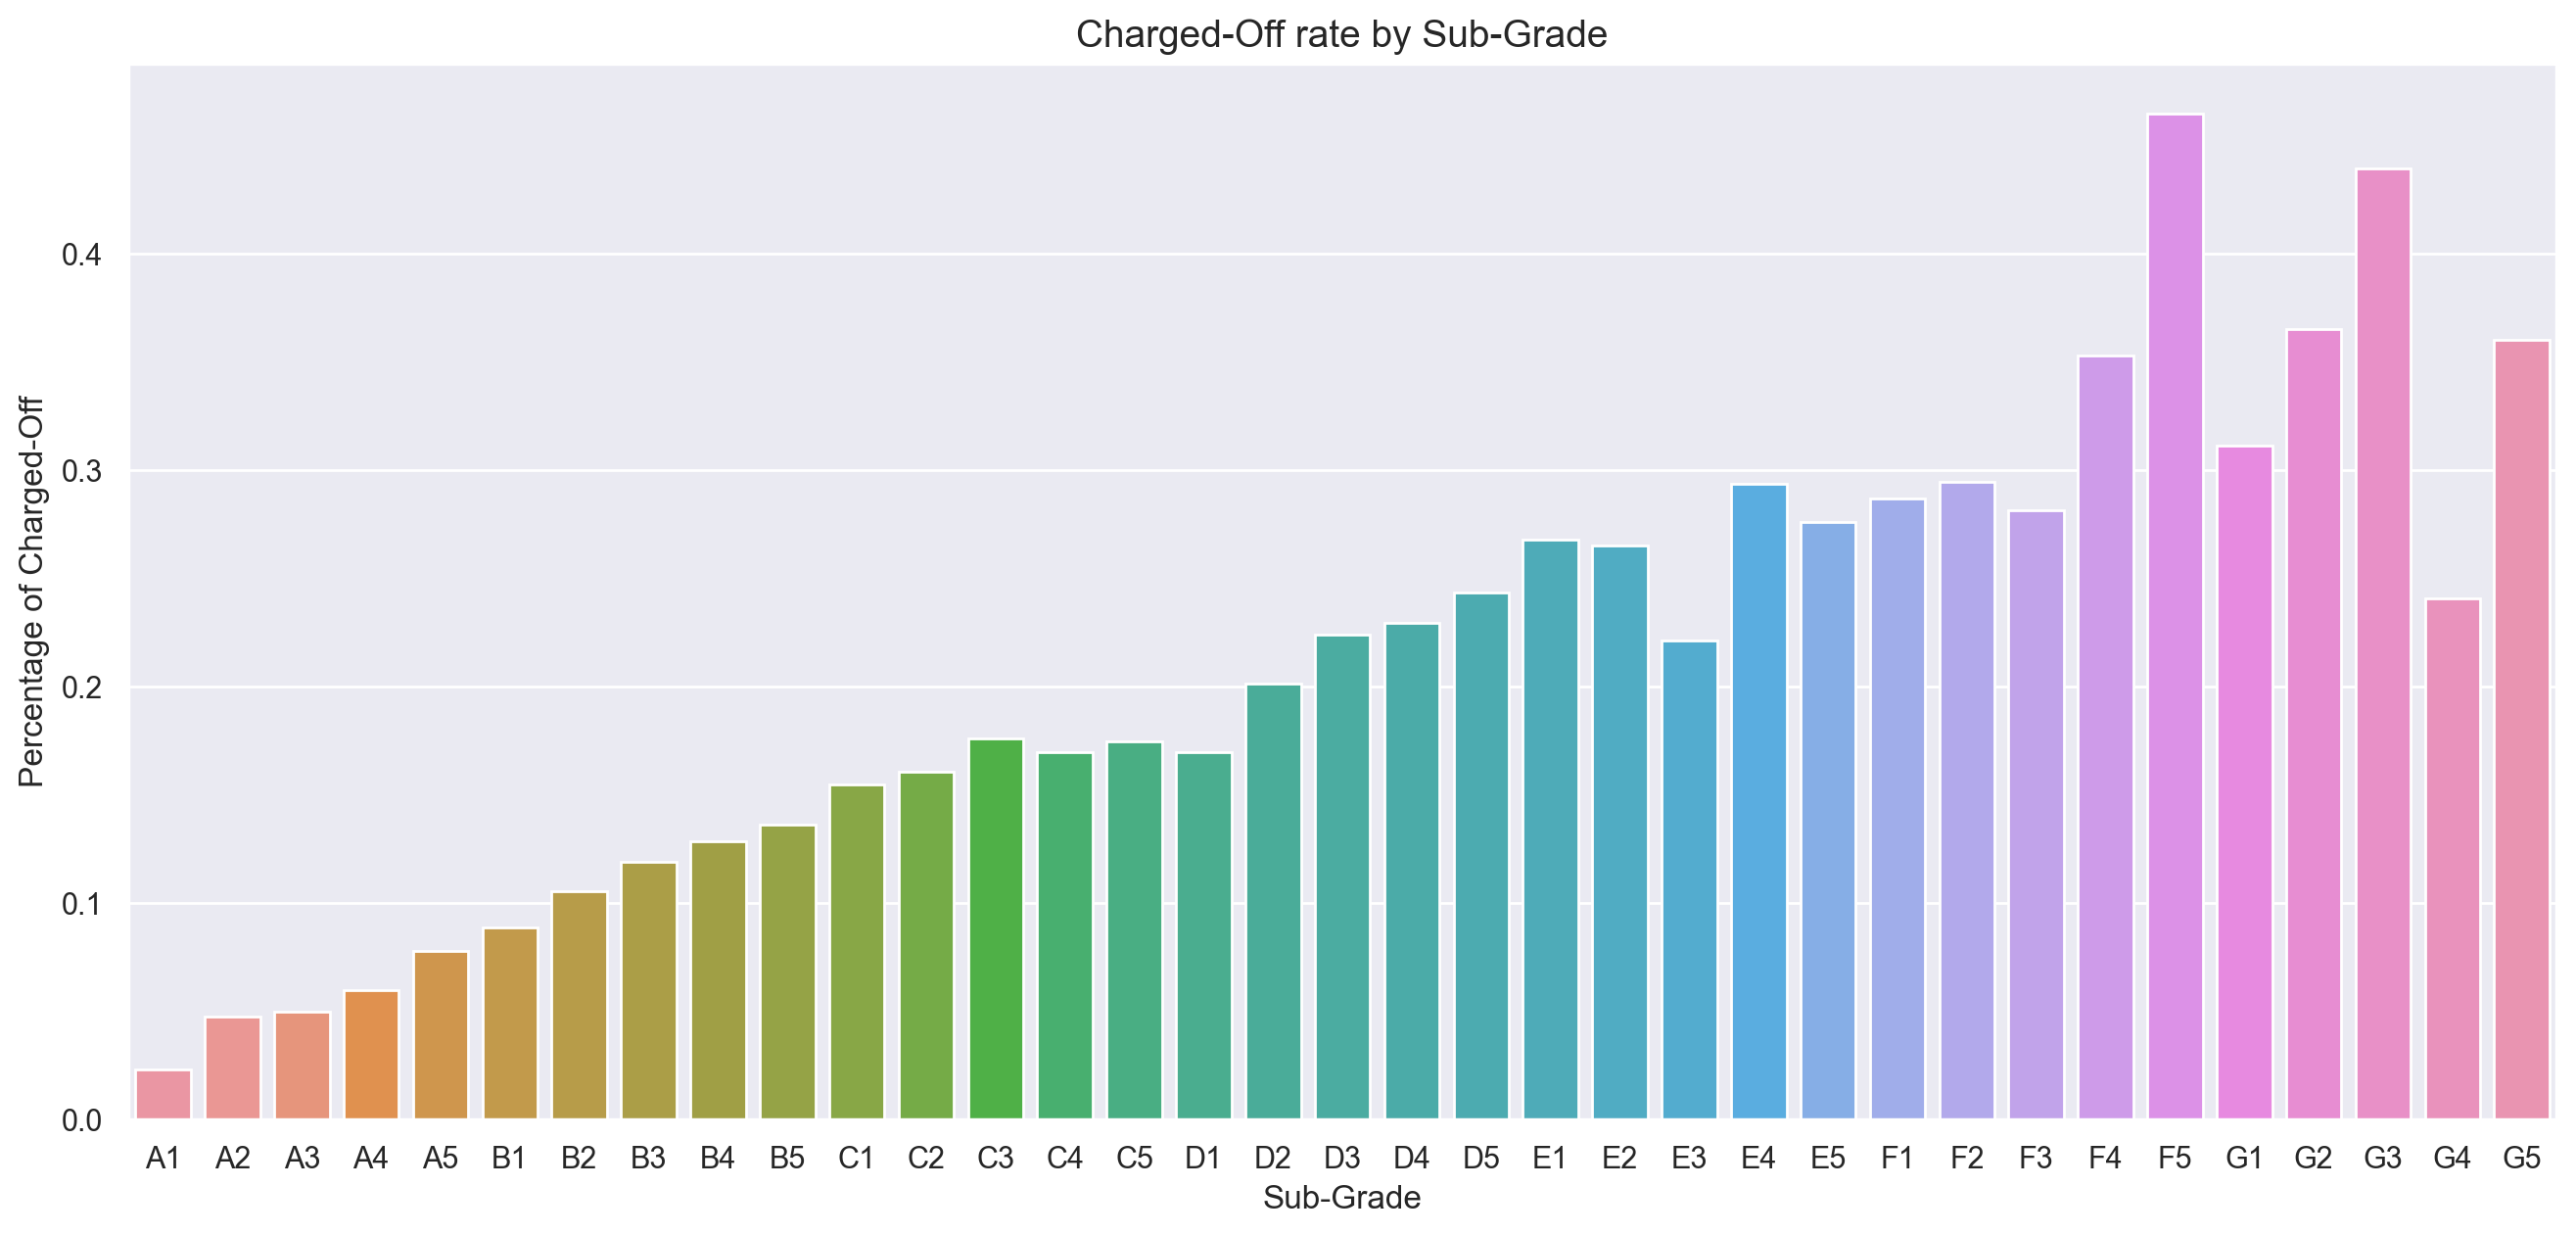

In [393]:
plt.figure(figsize=(16, 7), dpi=200)
sns.barplot(data=loans, x=charge_off_rates.index, y=charge_off_rates.values)
plt.xlabel("Sub-Grade", fontsize=12)
plt.ylabel("Percentage of Charged-Off", fontsize=12)
plt.title("Charged-Off rate by Sub-Grade", fontsize=14)
plt.show()

There's a clear trend of higher probability of charge-off as the sub grade worsens.

# 5.7) emp_title
##### Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [116]:
loans["emp_title"].value_counts()

emp_title
US Army                        129
Bank of America                106
IBM                             65
AT&T                            57
Kaiser Permanente               55
                              ... 
Schneider Finance                1
Shah Smith  and  Associates      1
friendship center golf cars      1
Crane 1 Services                 1
Fairfield Manufacturing          1
Name: count, Length: 27461, dtype: int64

In [117]:
loans["emp_title"].describe()

count       35427
unique      27461
top       US Army
freq          129
Name: emp_title, dtype: object

There are just way too many job titles for this feature to be useful. Hence, we drop it

In [118]:
loans.drop(labels="emp_title", axis=1, inplace=True)

# 5.8) emp_length
##### Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [119]:
loans["emp_length"].value_counts().sort_index()

emp_length
1 year       2968
10+ years    8036
2 years      4089
3 years      3840
4 years      3212
5 years      3052
6 years      2063
7 years      1639
8 years      1364
9 years      1179
< 1 year     3985
Name: count, dtype: int64

Convert emp_length to integers:

In [123]:
loans["emp_length"].replace(to_replace=["1 year", "10+ years", "2 years", "3 years", "4 years", "5 years", "6 years", "7 years", "8 years", "9 years", "< 1 year"], value=[1.0, 10.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 0.0], inplace=True)

Plotting a Histogram and Bar plot

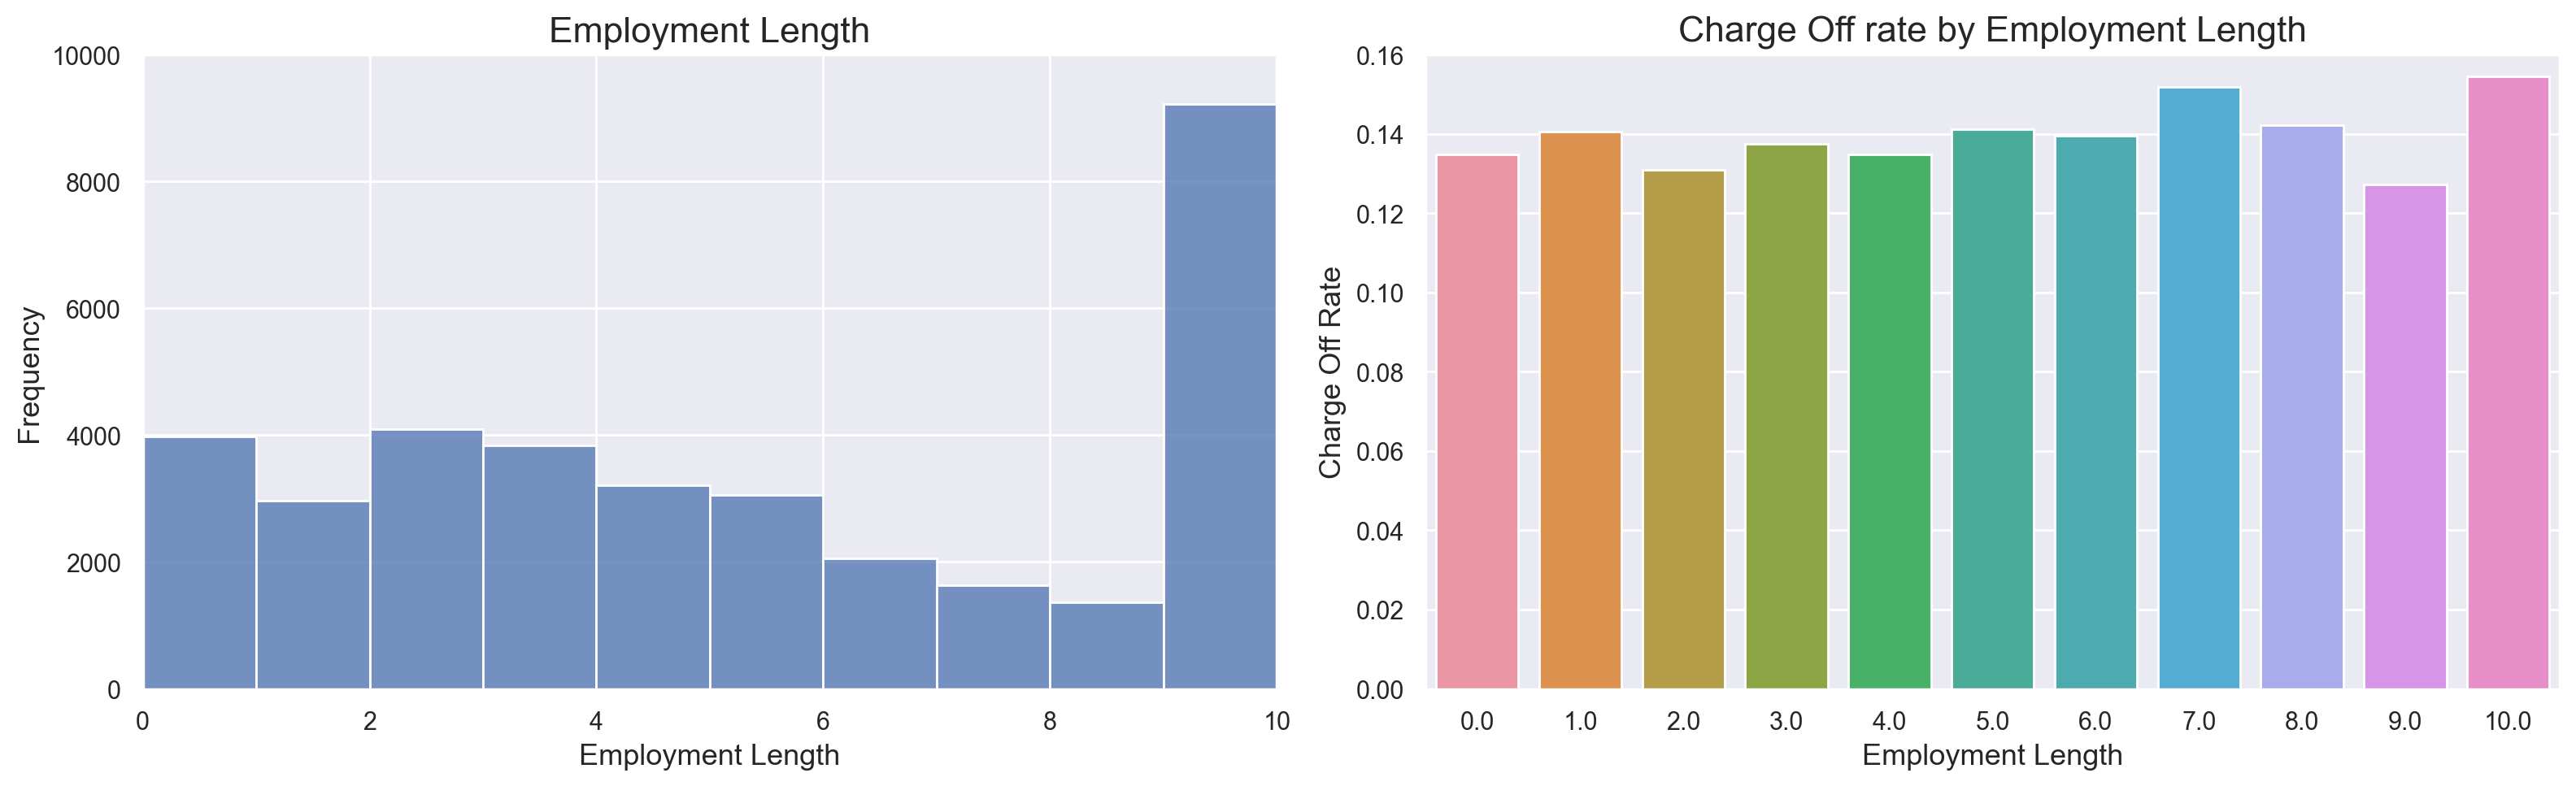

In [133]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=200)
ax1.margins(0)
ax2.margins(0)

sns.histplot(data=loans, x="emp_length", ax=ax1, bins=10)
ax1.set_title("Employment Length", fontsize=16)
ax1.set_xlabel("Employment Length", fontsize=13)
ax1.set_ylabel("Frequency", fontsize=13)
ax1.set_ylim(0, 10000)

charge_off_emp_length = loans.groupby("emp_length")['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
sns.barplot(data=loans, x=charge_off_emp_length.index, y=charge_off_emp_length.values, ax=ax2)
ax2.set_title("Charge Off rate by Employment Length", fontsize=16)
ax2.set_xlabel("Employment Length", fontsize=13)
ax2.set_ylabel("Charge Off Rate", fontsize=13)
ax2.set_ylim(0, 0.16)

plt.tight_layout()
plt.show()

Loan status does not appear to vary much with employment length on average, except for a small increase in charge-offs for borrowers with over 10 years of employment. 
Let's confirm this by plotting a scatterplot or a regplot

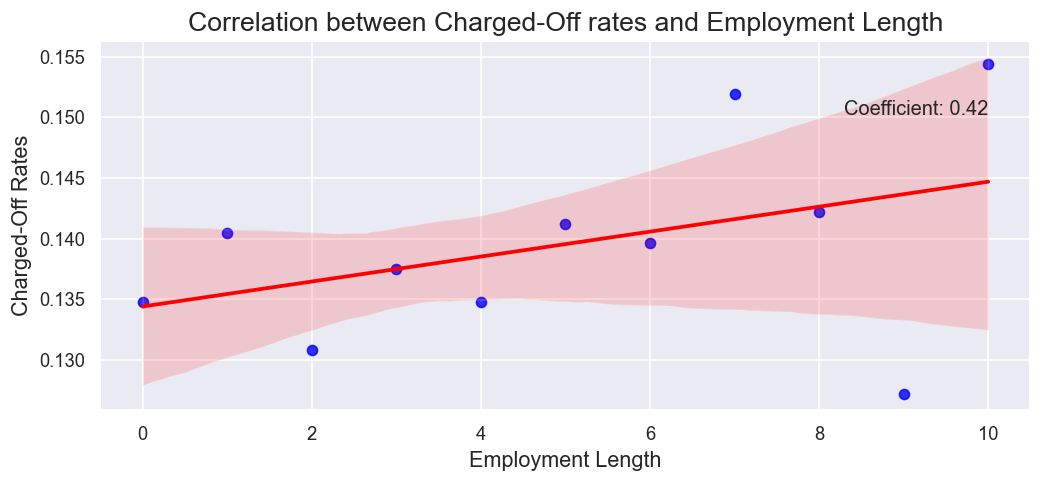

In [294]:
emp_length_coeff, _ = pearsonr(charge_off_emp_length.index, charge_off_emp_length.values)
plt.figure(figsize=(10,4), dpi=120)
sns.regplot(data=charge_off_emp_length, x=charge_off_emp_length.index, y=charge_off_emp_length.values, line_kws={"color": "red"}, scatter_kws={"color": "blue"})
plt.title("Correlation between Charged-Off rates and Employment Length", fontsize=16)
plt.xlabel("Employment Length", fontsize=13)
plt.ylabel("Charged-Off Rates", fontsize=13)
plt.text(0.8, 0.8, f"Coefficient: {emp_length_coeff:.2f}", transform=plt.gca().transAxes, fontsize=12)
plt.show()

# 5.9) home_ownership
##### Data Dictionary: "The homeownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [134]:
loans["home_ownership"].value_counts()

home_ownership
RENT        17109
MORTGAGE    15716
OWN          2508
OTHER          94
Name: count, dtype: int64

Charge-off rates by Home Ownership

In [143]:
charge_off_home_ownership = loans.groupby(by="home_ownership")["loan_status"].value_counts(normalize=True).loc[:, "Charged Off"]
charge_off_home_ownership

home_ownership
MORTGAGE    0.132031
OTHER       0.191489
OWN         0.139155
RENT        0.149687
Name: proportion, dtype: float64

Plotting Histogram and Bar Plot

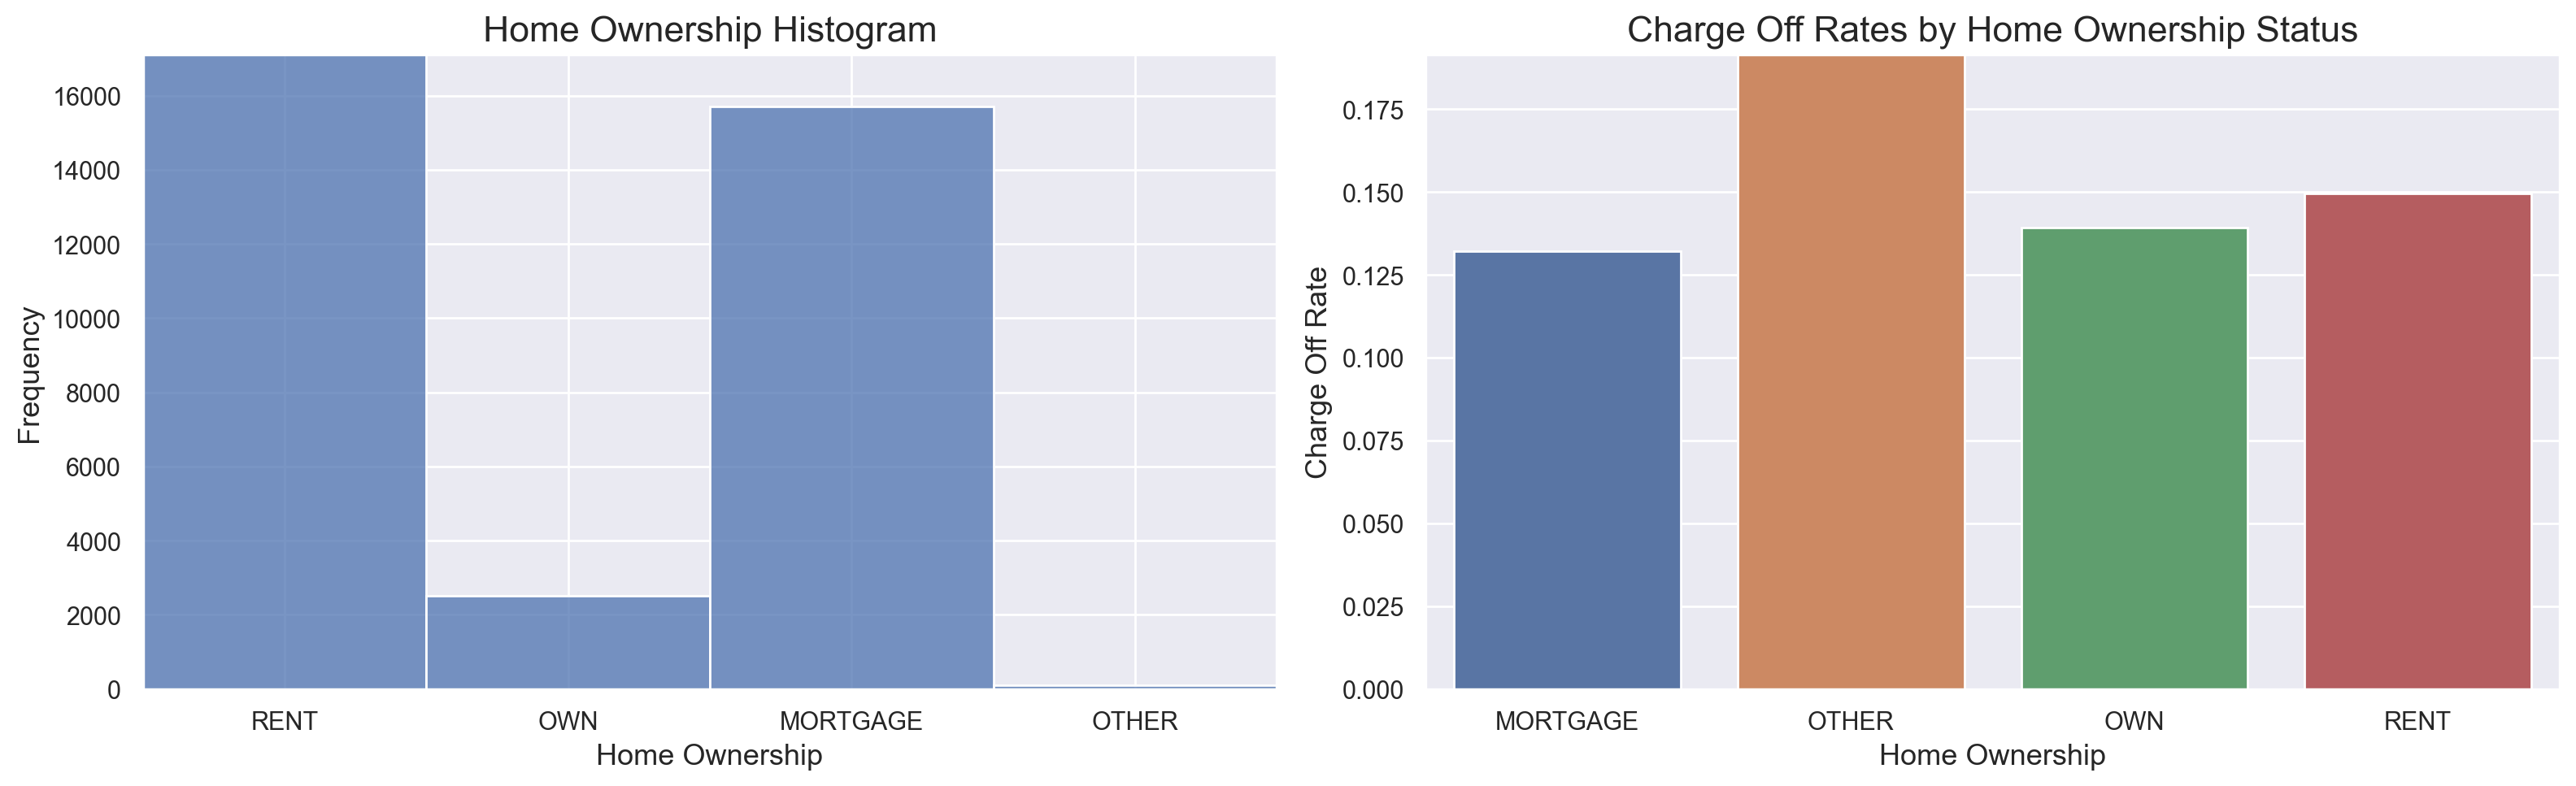

In [144]:
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=200)
ax1.margins(0)
ax2.margins(0)

sns.histplot(data=loans, x="home_ownership", ax=ax1)
ax1.set_title("Home Ownership Histogram", fontsize=16)
ax1.set_xlabel("Home Ownership", fontsize=13)
ax1.set_ylabel("Frequency", fontsize=13)

sns.barplot(data=loans, x=charge_off_home_ownership.index, y=charge_off_home_ownership.values, ax=ax2)
ax2.set_title("Charge Off Rates by Home Ownership Status", fontsize=16)
ax2.set_xlabel("Home Ownership", fontsize=13)
ax2.set_ylabel("Charge Off Rate", fontsize=13)

plt.tight_layout()
plt.show()

We see that charge off rate is slightly higher for the people who pay rent

# 5.10 annual_inc
##### Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [146]:
loans["annual_inc"].describe()

count    3.542700e+04
mean     6.905914e+04
std      6.392569e+04
min      4.000000e+03
25%      4.149600e+04
50%      6.000000e+04
75%      8.240000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

Because of the large range of incomes, we should take a log transform of the annual income variable

In [152]:
loans["annual_inc"] = loans["annual_inc"].apply(lambda x: np.log10(x + 1))

In [155]:
loans.drop(labels="log_annual_inc", axis=1, inplace=True)

KeyError: "['log_annual_inc'] not found in axis"

In [156]:
loans["annual_inc"].describe()

count    35427.000000
mean         4.769351
std          0.236064
min          3.602169
25%          4.618017
50%          4.778158
75%          4.915932
max          6.778151
Name: annual_inc, dtype: float64

Plotting a histogram and box plot

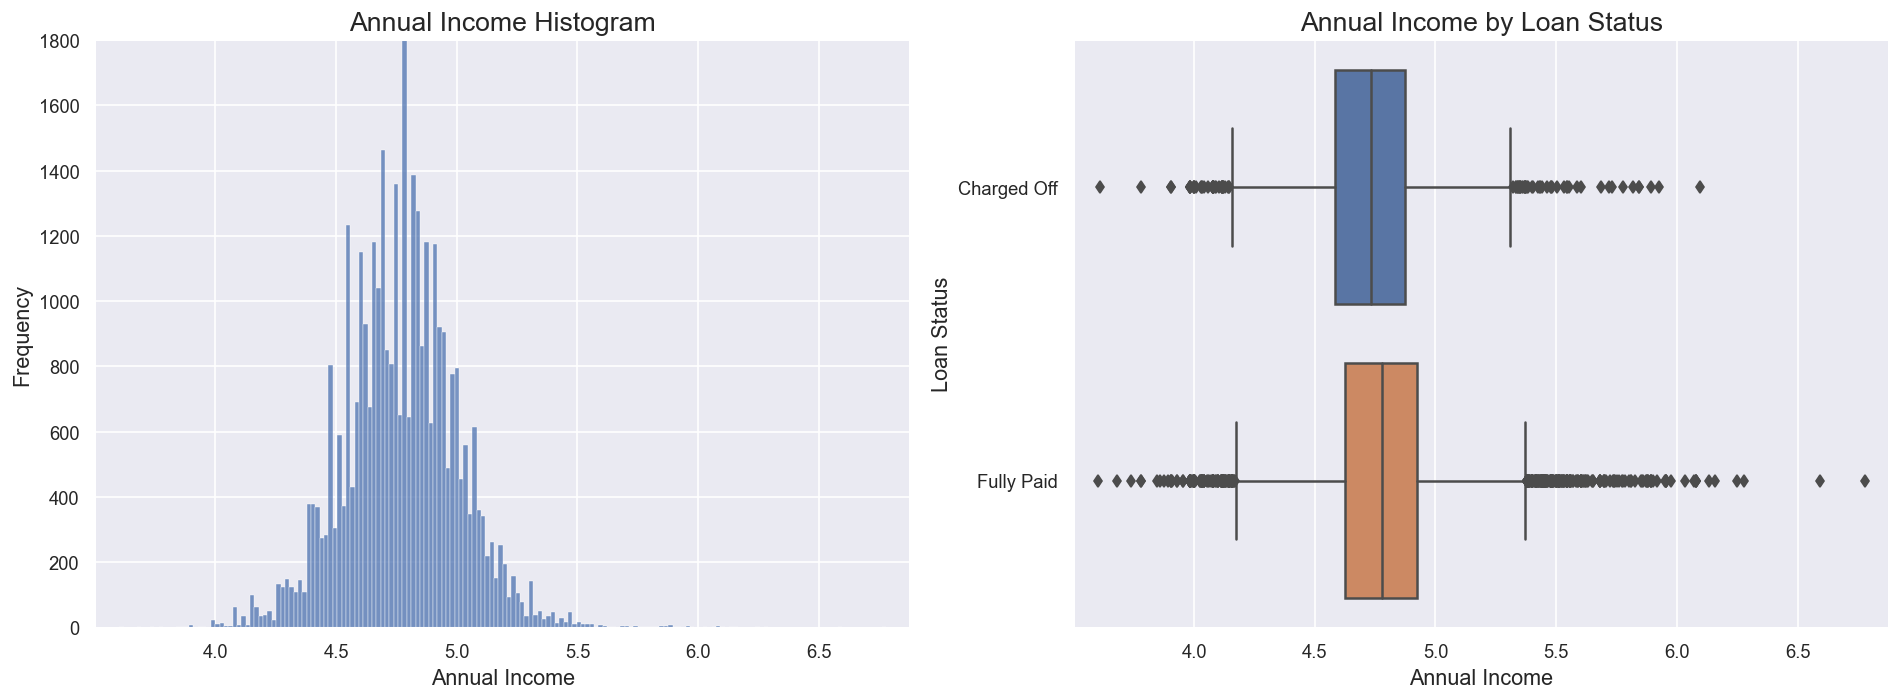

In [158]:
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), dpi=120)
ax1.margins(0)
ax2.margins(0)

sns.histplot(data=loans, x="annual_inc", ax=ax1)
ax1.set_title("Annual Income Histogram", fontsize=16)
ax1.set_xlabel("Annual Income", fontsize=13)
ax1.set_ylabel("Frequency", fontsize=13)
ax1.set_xlim(min(loans["annual_inc"]) - 0.1, max(loans["annual_inc"]) + 0.1)
ax1.set_ylim(0, 1800)

sns.boxplot(data=loans, x="annual_inc", y="loan_status", ax=ax2)
ax2.set_title("Annual Income by Loan Status", fontsize=16)
ax2.set_xlabel("Annual Income", fontsize=13)
ax2.set_ylabel("Loan Status", fontsize=13)
ax2.set_xlim(min(loans["annual_inc"]) - 0.1, max(loans["annual_inc"]) + 0.1)

plt.tight_layout()
plt.show()

Looks Like individuals with higher income are more likely to pay off their loans. Let's Confirm it with a Regression Plot

Charge-off rate by annual income

In [296]:
charge_off_rate_inc = loans.groupby("annual_inc")["loan_status"].value_counts(normalize=True)[:, "Charged Off"]
annual_inc_coeff, _ = pearsonr(charge_off_rate_inc.index, charge_off_rate_inc.values)
charge_off_rate_inc

annual_inc
3.610767    1.000000
3.778224    0.333333
3.903144    0.500000
3.982316    0.263158
4.000043    0.400000
              ...   
5.845099    1.000000
5.845132    1.000000
5.892095    0.200000
5.924280    1.000000
6.096910    1.000000
Name: proportion, Length: 1146, dtype: float64

Does Lower Income mean higher Charged-Off rates?

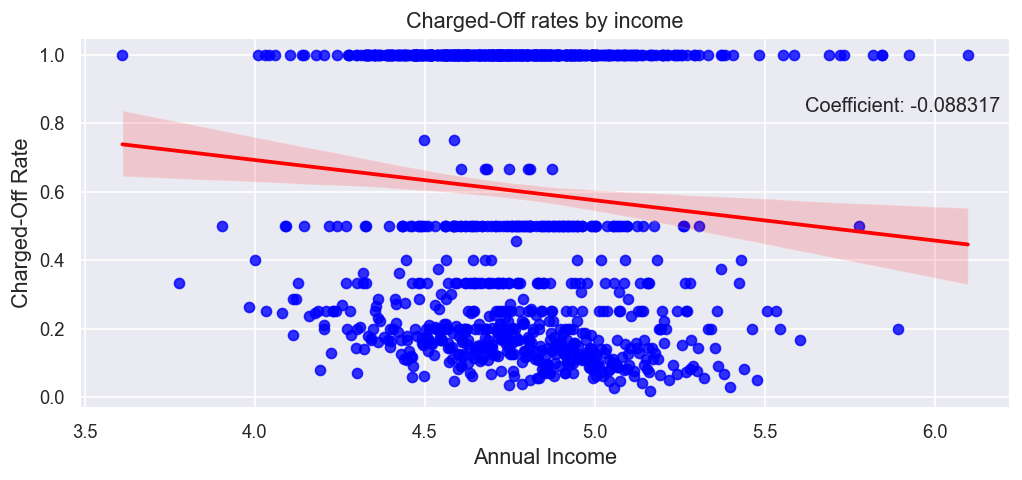

In [298]:
plt.figure(figsize=(10, 4), dpi=120)
sns.regplot(data=charge_off_rate_inc, x=charge_off_rate_inc.index, y=charge_off_rate_inc.values, line_kws={"color": "red"}, scatter_kws={"color": "blue"})
plt.xlabel("Annual Income", fontsize=13)
plt.ylabel("Charged-Off Rate", fontsize=13)
plt.title("Charged-Off rates by income", fontsize=13)
plt.text(0.78, 0.8, f"Coefficient: {annual_inc_coeff:2f}", transform=plt.gca().transAxes, fontsize=12)
plt.show()

That confirms it, individuals with high annual income tend to have lower charged-off rates.

In [160]:
loans.groupby('loan_status')['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5003.0,4.730124,0.235129,3.610767,4.584343,4.732402,4.875067,6.096910
Fully Paid,30424.0,4.775802,0.235596,3.602169,4.623260,4.778158,4.924284,6.778151


# 5.11 verification_status
##### Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified.

In [161]:
loans["verification_status"].value_counts()

verification_status
Not Verified       14870
Verified           11380
Source Verified     9177
Name: count, dtype: int64

In [162]:
charge_off_verify_status = loans.groupby(by="verification_status")["loan_status"].value_counts(normalize=True).loc[:, "Charged Off"]

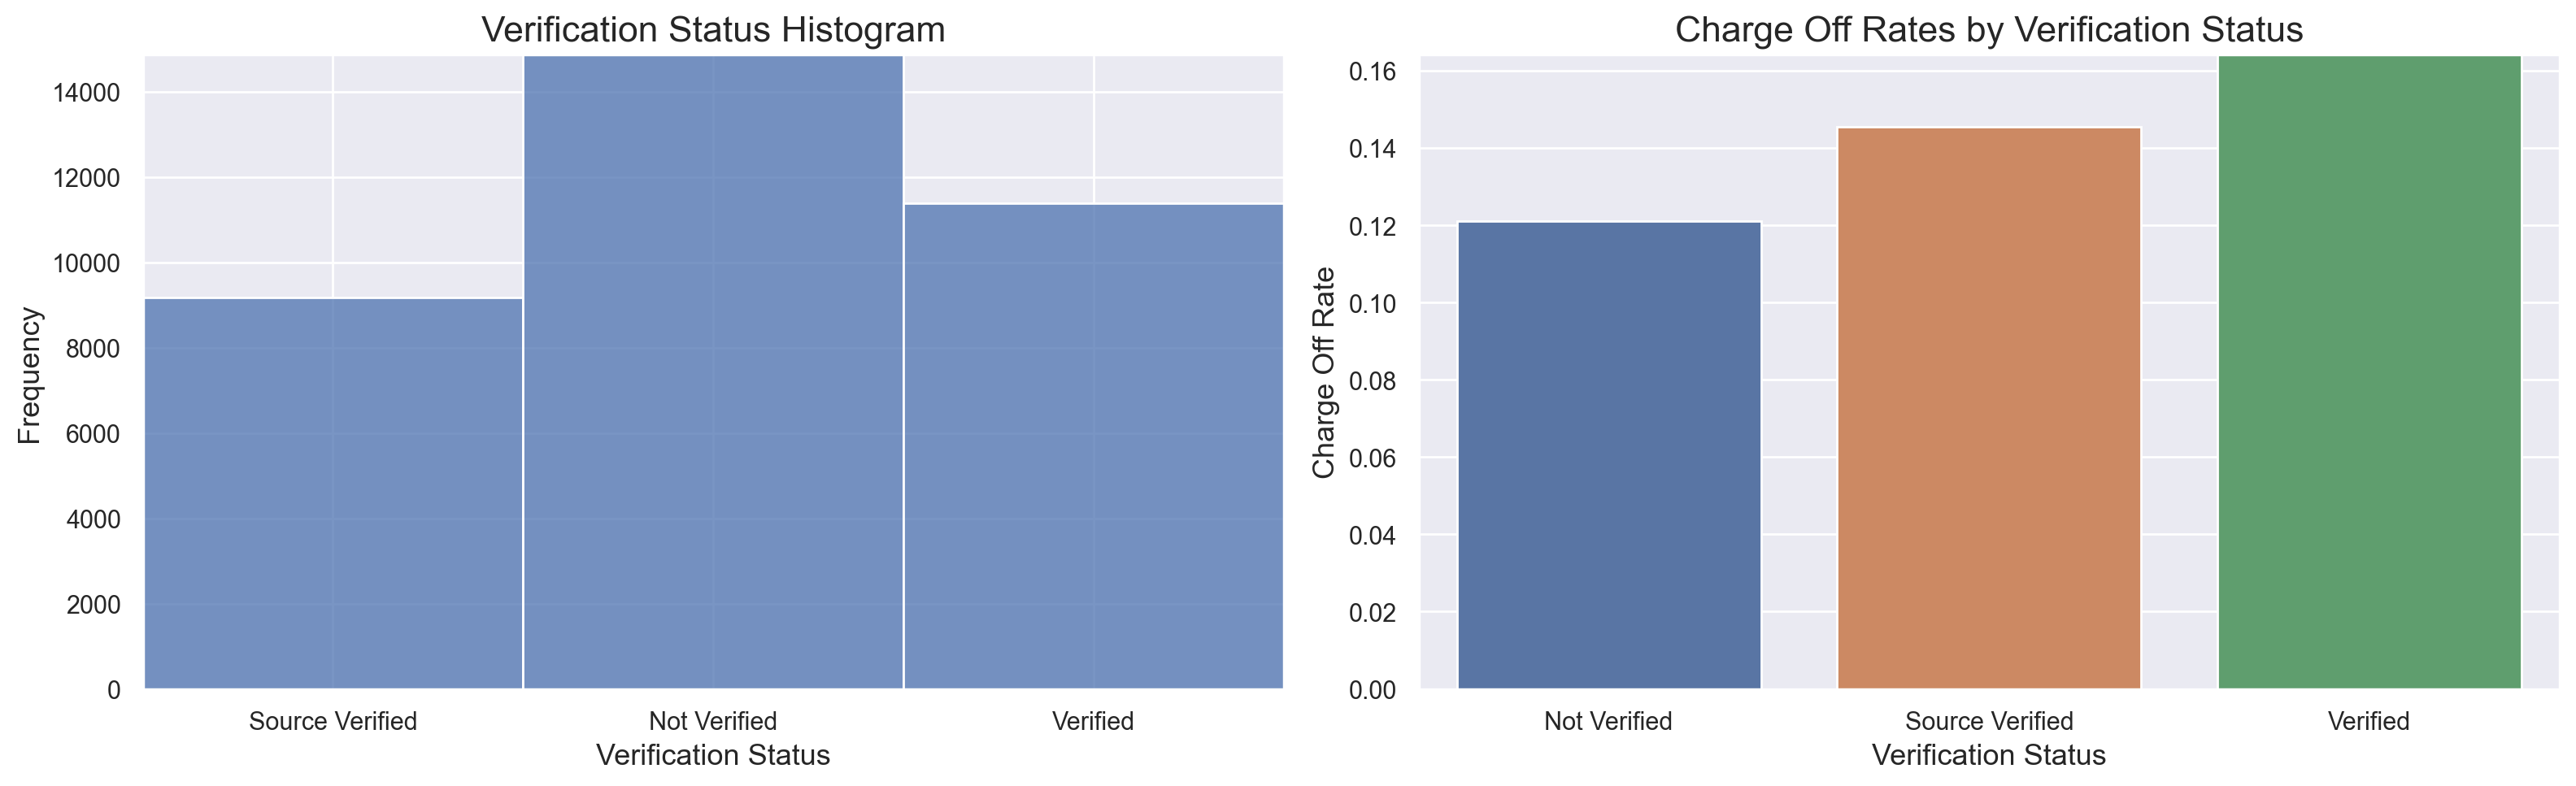

In [163]:
fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=200)
ax1.margins(0)
ax2.margins(0)

sns.histplot(data=loans, x="verification_status", ax=ax1)
ax1.set_title("Verification Status Histogram", fontsize=16)
ax1.set_xlabel("Verification Status", fontsize=13)
ax1.set_ylabel("Frequency", fontsize=13)

sns.barplot(data=loans, x=charge_off_verify_status.index, y=charge_off_verify_status.values, ax=ax2)
ax2.set_title("Charge Off Rates by Verification Status", fontsize=16)
ax2.set_xlabel("Verification Status", fontsize=13)
ax2.set_ylabel("Charge Off Rate", fontsize=13)

plt.tight_layout()
plt.show()

We see That individuals whose income is not verified tend to have lower charge off rate

# 5.12) issue_d
##### Data Dictionary: "The month which the loan was funded."

Because we're only using variables available to investors before the loan was funded, issue_d will not be included

In [166]:
loans.drop(labels="issue_d", axis=1, inplace=True)

# 5.13) purpose
##### Data Dictionary: "A category provided by the borrower for the loan request."

In [167]:
loans["purpose"].value_counts()

purpose
debt_consolidation    16938
credit_card            4627
other                  3469
home_improvement       2617
major_purchase         1977
car                    1395
small_business         1358
wedding                 871
medical                 622
moving                  523
vacation                332
house                   332
educational             278
renewable_energy         88
Name: count, dtype: int64

Calculate the charge-off rates by purpose:

In [171]:
charge_off_rates_purpose = loans.groupby("purpose")["loan_status"].value_counts(normalize=True)[:, "Charged Off"].sort_values()
charge_off_rates_purpose

purpose
major_purchase        0.098128
wedding               0.102181
credit_card           0.103739
car                   0.106810
home_improvement      0.114253
vacation              0.147590
debt_consolidation    0.149723
moving                0.151052
medical               0.152733
other                 0.159412
house                 0.162651
educational           0.169065
renewable_energy      0.181818
small_business        0.267305
Name: proportion, dtype: float64

Notice that 9% of completed loans on a major_purchase have a charged-off and 26% of completed loans  on small_business have a charged-off

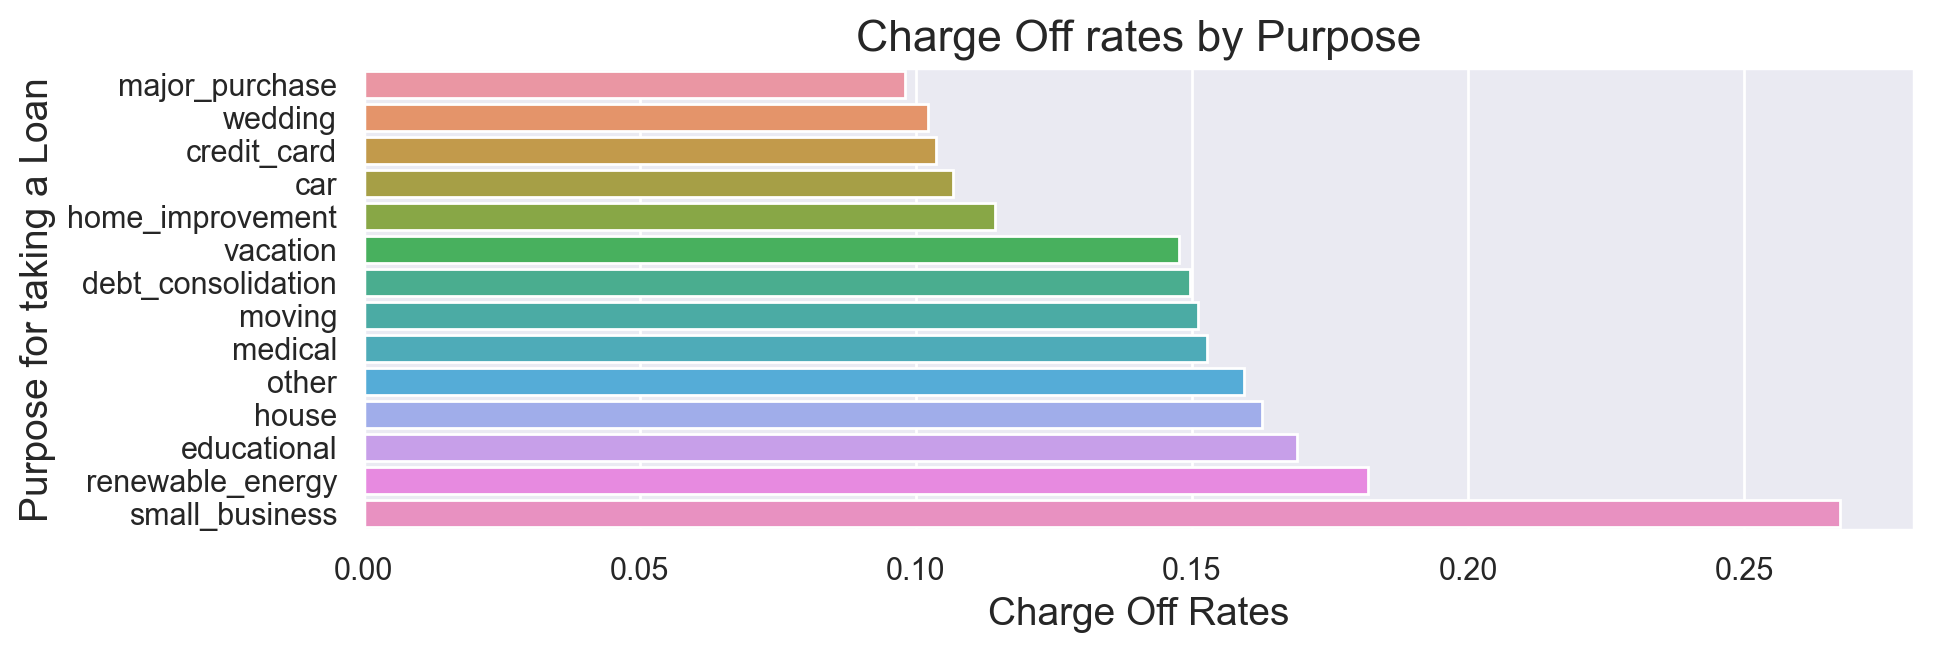

In [175]:
plt.figure(figsize=(10, 3), dpi=200)
sns.barplot(data=loans, x=charge_off_rates_purpose.values, y=charge_off_rates_purpose.index, orient="h")
plt.title("Charge Off rates by Purpose", fontsize=16)
plt.xlabel("Charge Off Rates", fontsize=14)
plt.ylabel("Purpose for taking a Loan", fontsize=14)
plt.show()

# 5.14) title
##### Data Dictionary: "The loan title provided by the borrower."

In [176]:
loans["title"].describe()

count                  35427
unique                 17684
top       Debt Consolidation
freq                    1977
Name: title, dtype: object

In [178]:
loans["title"].value_counts().head(10)

title
Debt Consolidation           1977
Debt Consolidation Loan      1545
Personal Loan                 591
Consolidation                 463
debt consolidation            440
Credit Card Consolidation     325
Home Improvement              325
Debt consolidation            303
Personal                      281
Credit Card Loan              280
Name: count, dtype: int64

based on the top 10 titles, the purpose variable appears to already contain this information. So we drop the title variable.

In [179]:
loans.drop(labels="title", axis=1, inplace=True)

# 5.15) zip_code
##### Data Dictionary for zip_code: "The first 3 numbers of the zip code provided by the borrower in the loan application."

In [181]:
loans["zip_code"].sample(5)

23063    112xx
34476    480xx
22454    156xx
33042    554xx
16411    920xx
Name: zip_code, dtype: object

In [182]:
loans["zip_code"].describe()

count     35427
unique      805
top       100xx
freq        527
Name: zip_code, dtype: object

# 5.16) addr_state
##### Data Dictionary for addr_state: "The state provided by the borrower in the loan application."

In [183]:
loans["addr_state"].describe()

count     35427
unique       49
top          CA
freq       6412
Name: addr_state, dtype: object

In [184]:
loans["addr_state"].value_counts()

addr_state
CA    6412
NY    3394
FL    2538
TX    2461
NJ    1670
IL    1382
PA    1374
VA    1263
GA    1255
MA    1181
OH    1098
MD     953
AZ     758
WA     720
CO     682
NC     674
CT     655
MI     642
MO     611
MN     555
NV     442
SC     422
AL     398
OR     397
LA     389
WI     387
KY     294
OK     272
KS     233
UT     229
AR     216
DC     203
RI     185
NM     163
WV     158
HI     153
NH     148
DE     105
WY      75
AK      73
MT      71
SD      55
VT      47
MS      18
TN      10
ID       3
IA       1
NE       1
IN       1
Name: count, dtype: int64

There are too many zip codes so let's drop the zip_code feature and only keep the addr_state

In [185]:
loans.drop(labels="zip_code", axis=1, inplace=True)

Calculate the charge-off rates by address state

In [187]:
charge_off_rates_addr_state = loans.groupby(by="addr_state")["loan_status"].value_counts(normalize=True)[:, "Charged Off"]
charge_off_rates_addr_state

addr_state
AK    0.205479
AL    0.120603
AR    0.115741
AZ    0.139842
CA    0.154710
CO    0.117302
CT    0.120611
DC    0.068966
DE    0.104762
FL    0.173365
GA    0.156175
HI    0.169935
IL    0.136035
KS    0.103004
KY    0.149660
LA    0.115681
MA    0.117697
MD    0.150052
MI    0.140187
MN    0.131532
MO    0.158756
MS    0.055556
MT    0.126761
NC    0.148368
NH    0.148649
NJ    0.155090
NM    0.171779
NV    0.219457
NY    0.131408
OH    0.127505
OK    0.136029
OR    0.158690
PA    0.117176
RI    0.135135
SC    0.142180
SD    0.181818
TN    0.200000
TX    0.114181
UT    0.144105
VA    0.130641
VT    0.127660
WA    0.152778
WI    0.126615
WV    0.132911
WY    0.040000
Name: proportion, dtype: float64

The charge-off rate ranges from 4.0% in Wyoming to 20% in Alaska.

Plotting a histogram and bar plot of addr_state

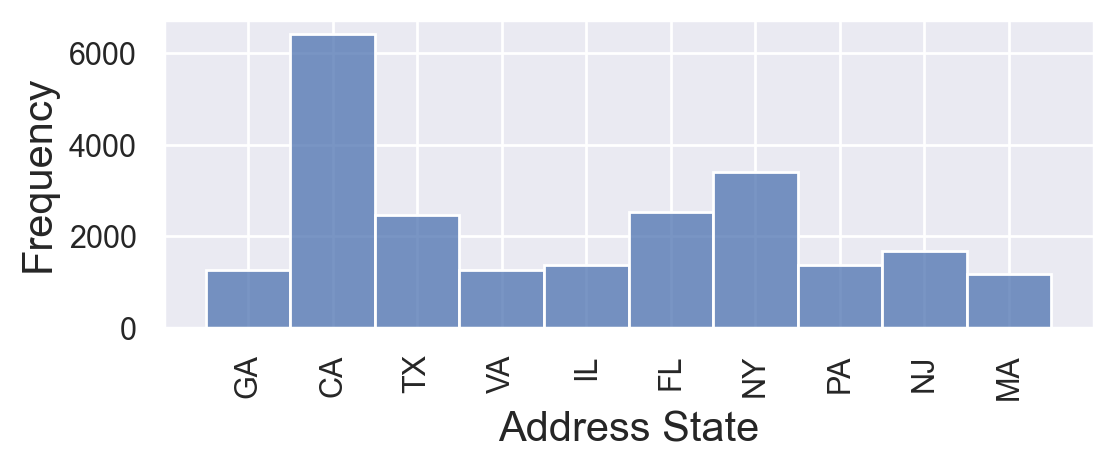

In [394]:
top_states = loans["addr_state"].value_counts().nlargest(10)
plt.figure(figsize=(6, 2), dpi=200)
sns.histplot(data=loans[loans["addr_state"].isin(top_states.index)], x="addr_state")
plt.xlabel("Address State", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xticks(rotation=90)
plt.show()

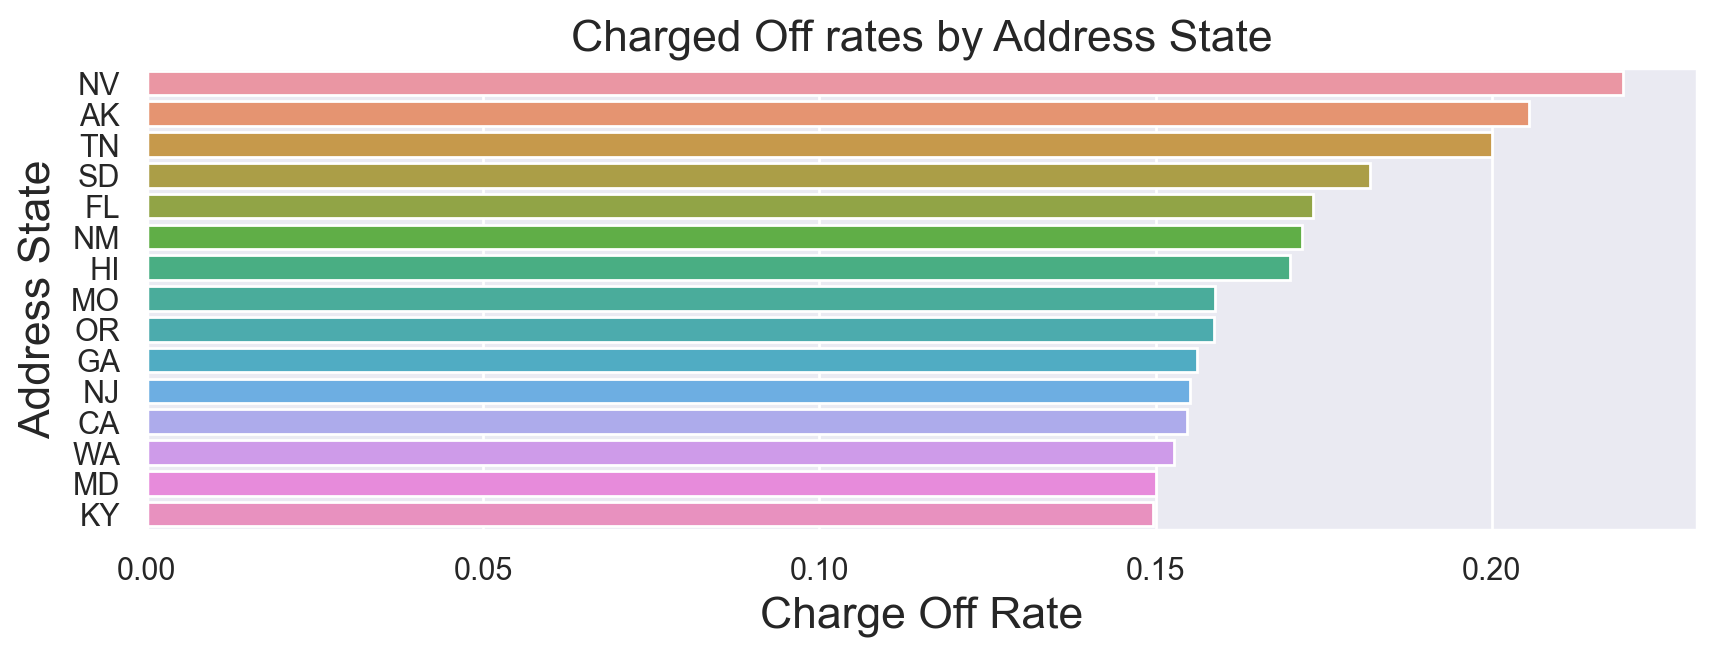

In [217]:
plt.figure(figsize=(10, 3), dpi=200)
charge_off_states = loans.groupby("addr_state")['loan_status'].value_counts(normalize=True)[:, "Charged Off"].nlargest(15)
sns.barplot(x=charge_off_states.values, y=charge_off_states.index, orient="h")
plt.xlabel("Charge Off Rate", fontsize=16)
plt.ylabel("Address State", fontsize=16)
plt.title("Charged Off rates by Address State", fontsize=16)
plt.show()

We see that Nevada has the top Charged - Off rates and that California is also in the top 15 list and the most loans are also from California seeing the histogram.

# 5.17) dti
##### Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."

In [219]:
loans["dti"].describe()

count    35427.000000
mean        13.402182
std          6.636947
min          0.000000
25%          8.320000
50%         13.500000
75%         18.640000
max         29.990000
Name: dti, dtype: float64

Let's see how this feature is distributed 

<Figure size 900x360 with 0 Axes>

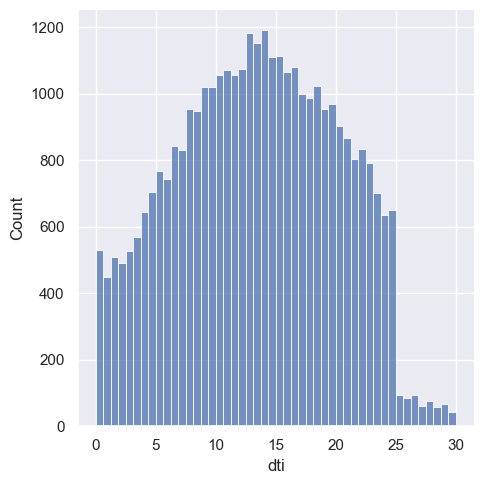

In [226]:
plt.figure(figsize=(10, 4), dpi=90)
sns.displot(loans["dti"], kde=False)
plt.show()

Does higher Dti means higher charged off rate?

In [299]:
charge_off_rates_dti = loans.groupby("dti")["loan_status"].value_counts(normalize=True)[:, "Charged Off"]
dti_coeff, _ = pearsonr(charge_off_rates_dti.index, charge_off_rates_dti)
charge_off_rates_dti

dti
0.00     0.164286
0.01     0.500000
0.08     0.200000
0.14     0.333333
0.22     0.166667
           ...   
29.45    1.000000
29.58    1.000000
29.60    1.000000
29.62    0.500000
29.85    1.000000
Name: proportion, Length: 2138, dtype: float64

Plotting a scatter plot between pti and charged-off rates

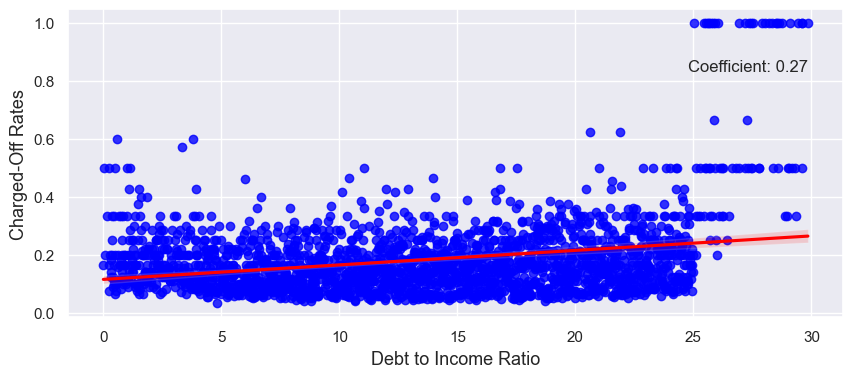

In [300]:
plt.figure(figsize=(10,4), dpi=100)
sns.regplot(data=charge_off_rates_dti, x=charge_off_rates_dti.index, y=charge_off_rates_dti.values, fit_reg=True, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel("Debt to Income Ratio", fontsize=13)
plt.ylabel("Charged-Off Rates", fontsize=13)
plt.text(0.8, 0.8, f"Coefficient: {dti_coeff:.2f}", transform=plt.gca().transAxes, fontsize=12)
plt.show()

We see that as the Debt to Income Ratio Increases The Charged-Off rates tend to Increase.
Let's compare the summary statistics by loan status

In [242]:
loans.groupby("loan_status")["dti"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5003.0,14.139232,6.528829,0.0,9.30,14.440,19.325,29.85
Fully Paid,30424.0,13.280979,6.646843,0.0,8.16,13.345,18.530,29.99


Completed loans that are charged off tend to have higher debt-to-income ratios.

# 5.18) earliest_cr_line 
##### Data Dictionary: "The month the borrower's earliest reported credit line was opened."

In [243]:
loans["earliest_cr_line"].describe()

count      35427
unique       509
top       Oct-99
freq         342
Name: earliest_cr_line, dtype: object

In [244]:
loans["earliest_cr_line"].value_counts()

earliest_cr_line
Oct-99    342
Nov-98    341
Dec-98    319
Oct-00    316
Nov-99    295
         ... 
Jun-69      1
Feb-66      1
Aug-73      1
Dec-68      1
May-72      1
Name: count, Length: 509, dtype: int64

Let's just retain the year for simplicity:

In [247]:
def convert_to_4_digit_year(year):
    year = int(year)
    if 0 <= year <= 21:
        return 2000 + year
    else:
        return 1900 + year
loans["earliest_cr_line"] = loans["earliest_cr_line"].str.split("-").str[1].apply(lambda x: convert_to_4_digit_year(x))

In [249]:
loans["earliest_cr_line"].describe()

count    35427.000000
mean      1996.822903
std          6.568860
min       1946.000000
25%       1994.000000
50%       1998.000000
75%       2001.000000
max       2008.000000
Name: earliest_cr_line, dtype: float64

Plotting a box plot and histogram

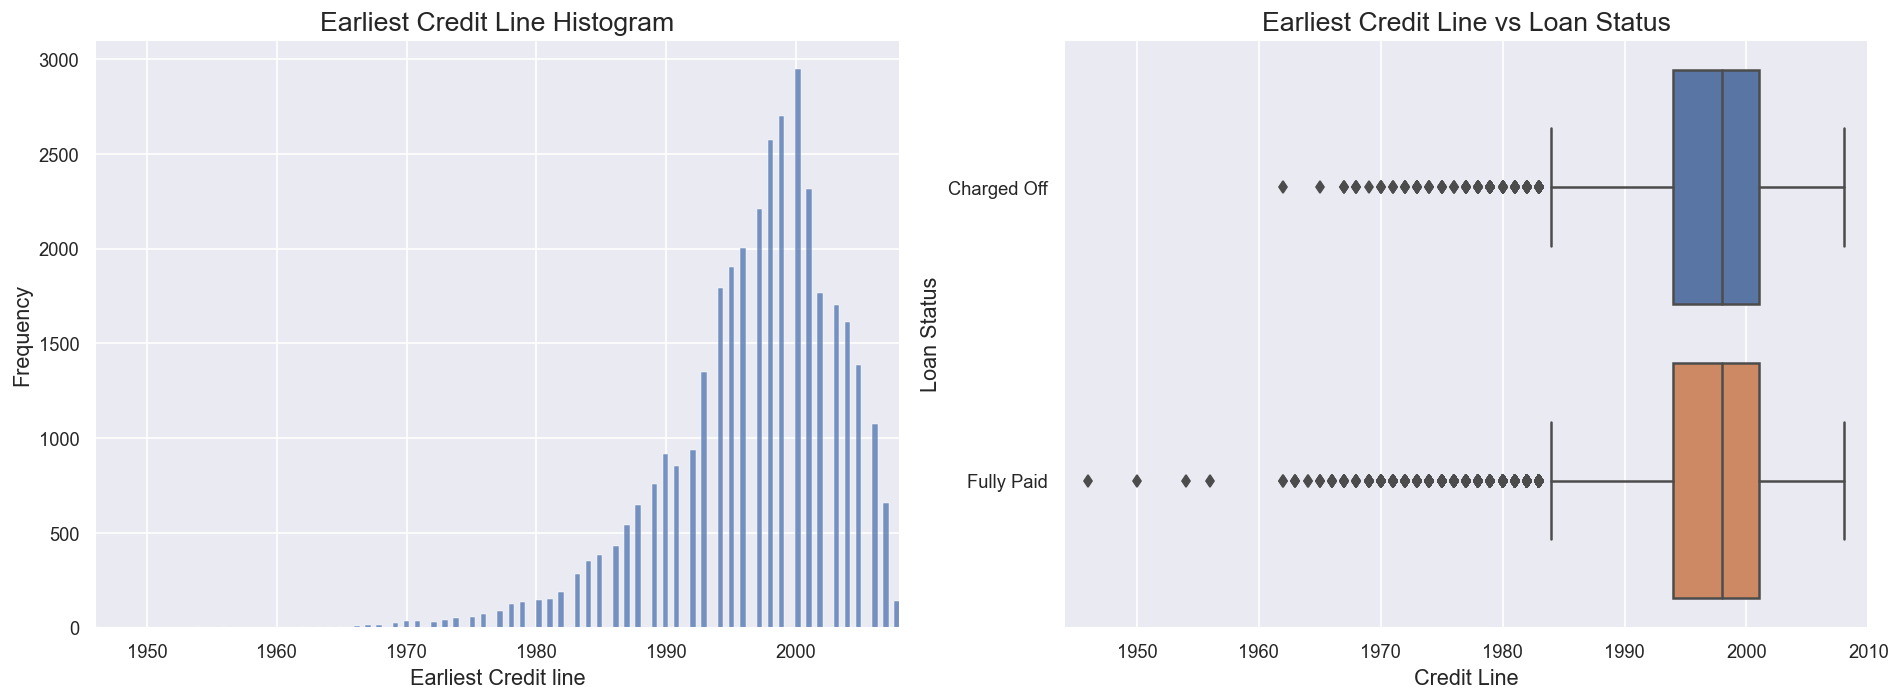

In [256]:
f3, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), dpi=120)
ax1.margins(0)
ax2.margins(0)

sns.histplot(data=loans, x="earliest_cr_line", ax=ax1)
ax1.set_title("Earliest Credit Line Histogram", fontsize=16)
ax1.set_xlabel("Earliest Credit line", fontsize=13)
ax1.set_ylabel("Frequency", fontsize=13)
ax1.set_ylim(0, 3100)

sns.boxplot(data=loans, x="earliest_cr_line", y="loan_status", ax=ax2)
ax2.set_title("Earliest Credit Line vs Loan Status", fontsize=16)
ax2.set_xlabel("Credit Line", fontsize=13)
ax2.set_ylabel("Loan Status", fontsize=13)
ax2.set_xlim(min(loans["earliest_cr_line"]) - 2, max(loans["earliest_cr_line"]) + 2)

plt.tight_layout()
plt.show()

Borrowers who are charged-off tend to have shorter lines of credit. Let's confirm that with a regression plot

In [301]:
charge_off_vs_credit_line = loans.groupby("earliest_cr_line")["loan_status"].value_counts(normalize=True)[:, "Charged Off"]
cr_line_coeff, _ = pearsonr(charge_off_vs_credit_line.index, charge_off_vs_credit_line.values)
charge_off_vs_credit_line

earliest_cr_line
1962    0.333333
1965    0.200000
1967    0.250000
1968    0.333333
1969    0.045455
1970    0.114286
1971    0.090909
1972    0.172414
1973    0.179487
1974    0.081633
1975    0.105263
1976    0.042857
1977    0.103448
1978    0.111111
1979    0.210526
1980    0.068966
1981    0.106667
1982    0.127660
1983    0.162544
1984    0.103152
1985    0.155844
1986    0.102804
1987    0.129870
1988    0.149068
1989    0.121854
1990    0.125683
1991    0.145369
1992    0.122732
1993    0.129176
1994    0.131285
1995    0.143908
1996    0.125187
1997    0.151200
1998    0.149747
1999    0.147723
2000    0.155593
2001    0.139585
2002    0.129892
2003    0.117578
2004    0.130893
2005    0.160779
2006    0.189944
2007    0.204856
2008    0.185714
Name: proportion, dtype: float64

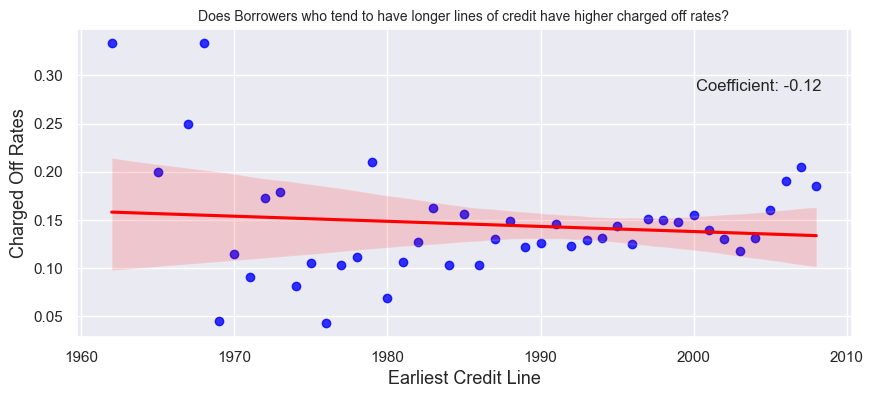

In [392]:
plt.figure(figsize=(10,4), dpi=100)
sns.regplot(x=charge_off_vs_credit_line.index, y=charge_off_vs_credit_line.values, line_kws={"color": "red"}, scatter_kws={"color": "blue"})
plt.title("Does Borrowers who tend to have longer lines of credit have higher charged off rates?", fontsize=10)
plt.xlabel("Earliest Credit Line", fontsize=13)
plt.ylabel("Charged Off Rates", fontsize=13)
plt.text(0.8, 0.8, f"Coefficient: {cr_line_coeff:.2f}", transform=plt.gca().transAxes, fontsize=12)
plt.show()

That Confirms it

# 5.19 open_acc
##### Data Dictionary: "The number of open credit lines in the borrower's credit file."

In [305]:
loans["open_acc"].describe()

count    35427.000000
mean         9.328535
std          4.374185
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64

In [396]:
loans["open_acc"].value_counts(normalize=True).sort_index()

open_acc
2     0.013577
3     0.036554
4     0.057809
5     0.079600
6     0.099613
7     0.101448
8     0.099105
9     0.094504
10    0.080842
11    0.070229
12    0.058063
13    0.048325
14    0.037457
15    0.030175
16    0.023908
17    0.018630
18    0.013803
19    0.010190
20    0.007424
21    0.006266
22    0.003613
23    0.002343
24    0.001807
25    0.001411
26    0.000819
27    0.000565
28    0.000621
29    0.000339
30    0.000367
31    0.000141
32    0.000056
33    0.000085
34    0.000141
35    0.000028
36    0.000056
38    0.000028
39    0.000028
44    0.000028
Name: proportion, dtype: float64

In [398]:
charge_off_rates_open_acc = loans.groupby("open_acc")["loan_status"].value_counts(normalize=True)[:, "Charged Off"]
open_acc_coeff, _ = pearsonr(charge_off_rates_open_acc.index, charge_off_rates_open_acc.values)
charge_off_rates_open_acc

open_acc
2     0.205821
3     0.162934
4     0.149902
5     0.130496
6     0.136016
7     0.137451
8     0.138422
9     0.139785
10    0.146997
11    0.141077
12    0.134176
13    0.142523
14    0.147702
15    0.144060
16    0.109799
17    0.145455
18    0.134969
19    0.155125
20    0.144487
21    0.144144
22    0.117188
23    0.132530
24    0.093750
25    0.200000
26    0.206897
27    0.250000
28    0.181818
29    0.083333
30    0.230769
31    0.400000
33    0.666667
34    0.200000
38    1.000000
Name: proportion, dtype: float64

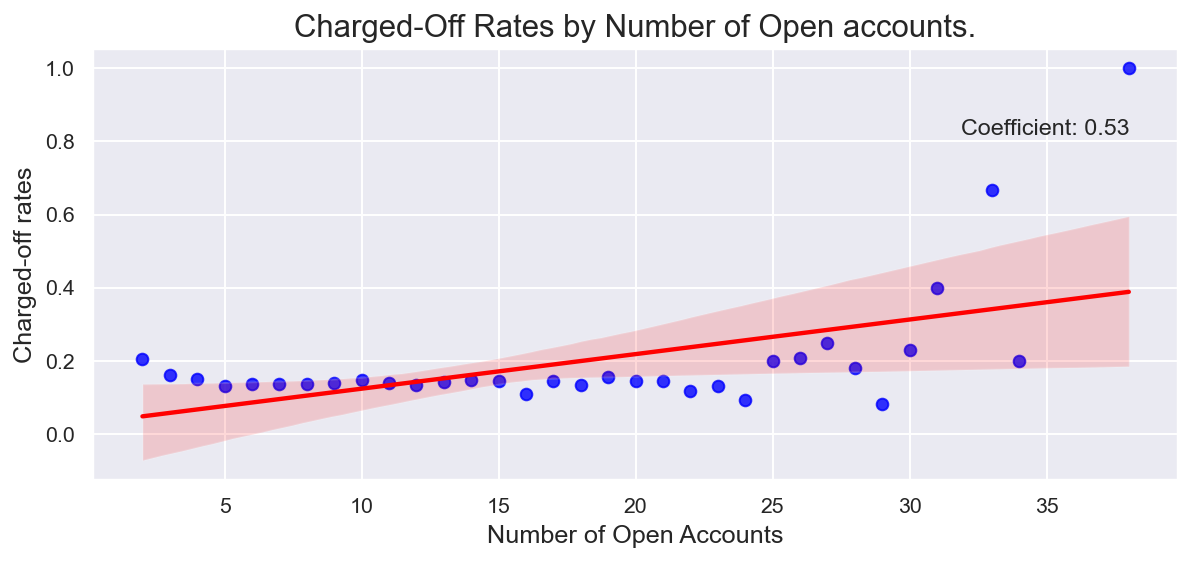

In [402]:
plt.figure(figsize=(10, 4), dpi=140)
sns.regplot(x=charge_off_rates_open_acc.index, y=charge_off_rates_open_acc, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel("Number of Open Accounts", fontsize=13)
plt.ylabel("Charged-off rates", fontsize=13)
plt.title("Charged-Off Rates by Number of Open accounts.", fontsize=16)
plt.text(0.8, 0.8, f"Coefficient: {open_acc_coeff:.2}", transform=plt.gca().transAxes, fontsize=12)
plt.show()

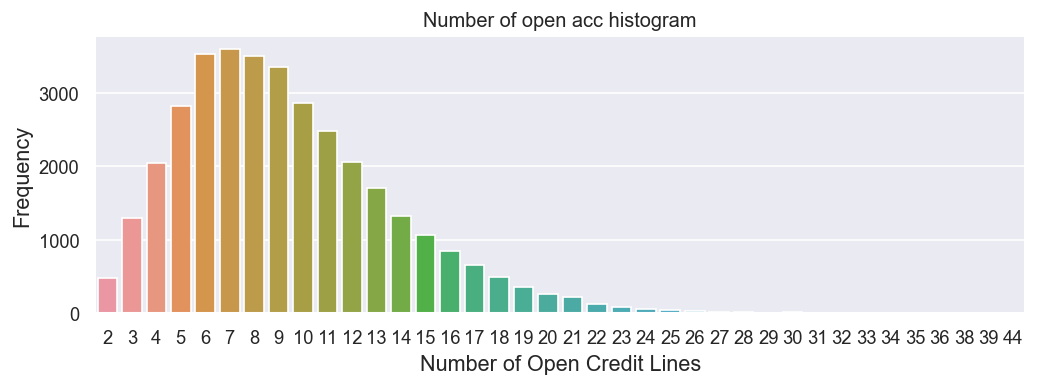

In [309]:
plt.figure(figsize=(10,3), dpi=120)
sns.countplot(data=loans, x=loans["open_acc"])
plt.xlabel("Number of Open Credit Lines", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.title("Number of open acc histogram")
plt.show()

Is there a difference in number of credit lines between fully paid loans and charged-off loans?

In [310]:
loans.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5003.0,9.284229,4.484765,2.0,6.0,9.0,12.0,38.0
Fully Paid,30424.0,9.335820,4.355764,2.0,6.0,9.0,12.0,44.0


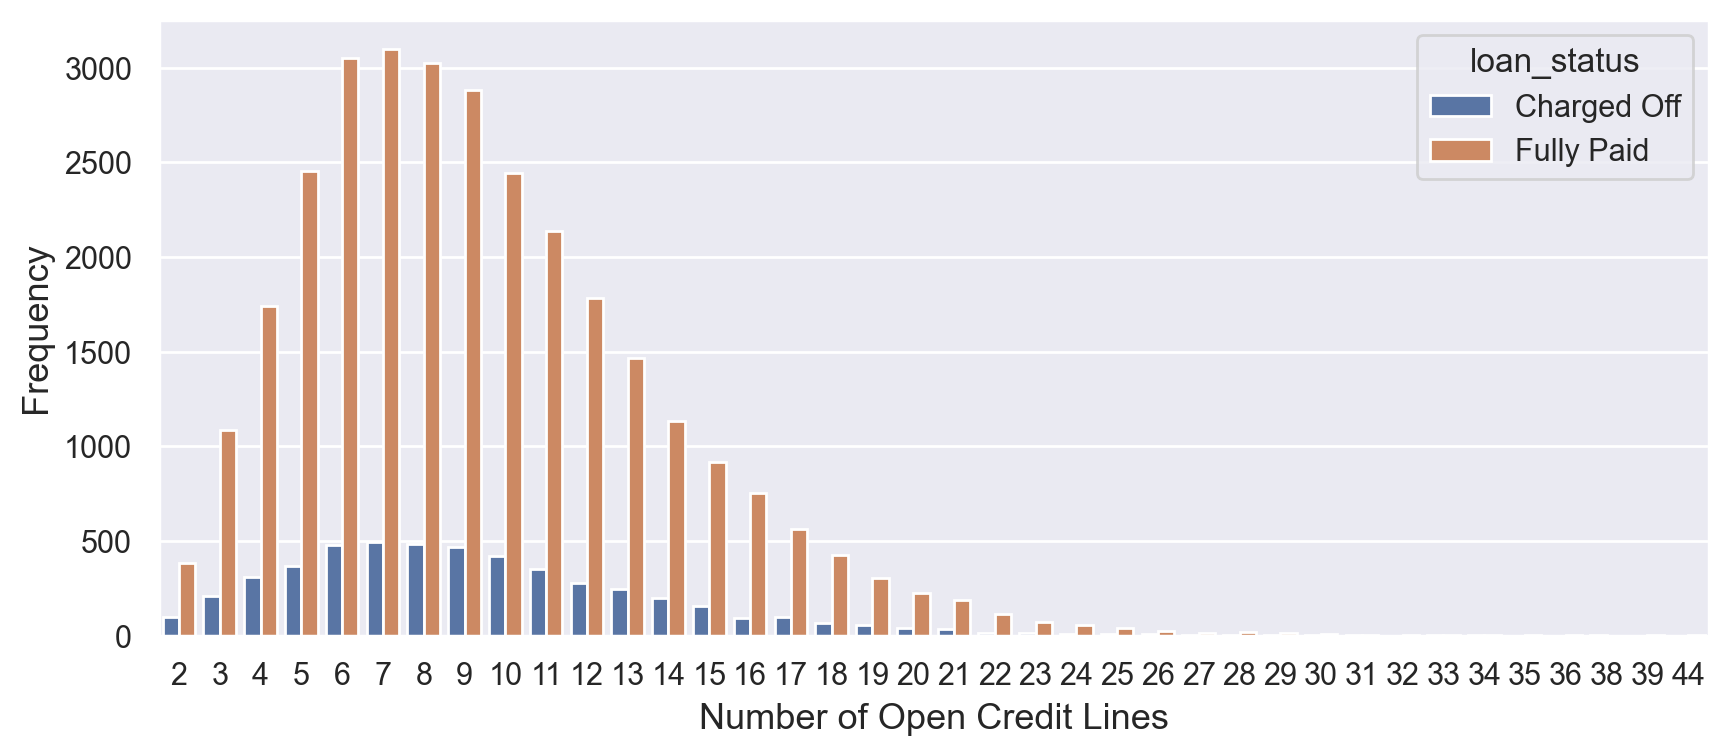

In [315]:
plt.figure(figsize=(10,4), dpi=200)
sns.countplot(data=loans, x=loans["open_acc"], hue=loans["loan_status"])
plt.ylabel("Frequency", fontsize=13)
plt.xlabel("Number of Open Credit Lines", fontsize=13)
plt.show()

# 5.20) pub_rec
###### Data Dictionary: "Number of derogatory public records."

In [316]:
loans["pub_rec"].value_counts()

pub_rec
0    33569
1     1805
2       44
3        7
4        2
Name: count, dtype: int64

Is there a difference in average public records between fully paid loans and charged-off loans?

In [317]:
loans.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5003.0,0.082950,0.282990,0.0,0.0,0.0,0.0,2.0
Fully Paid,30424.0,0.049533,0.226905,0.0,0.0,0.0,0.0,4.0


what is the percentage of people that had a charged-off, who previously also had a charged off?

In [321]:
charge_off_rates_pub_rec = loans.groupby("pub_rec")["loan_status"].value_counts(normalize=True)[:, "Charged Off"]
charge_off_rates_pub_rec

pub_rec
0    0.136972
1    0.218837
2    0.227273
Name: proportion, dtype: float64

We see that people who previously had a charged-off account are more likely to charge-off again. Let's Confirm that with a plot.

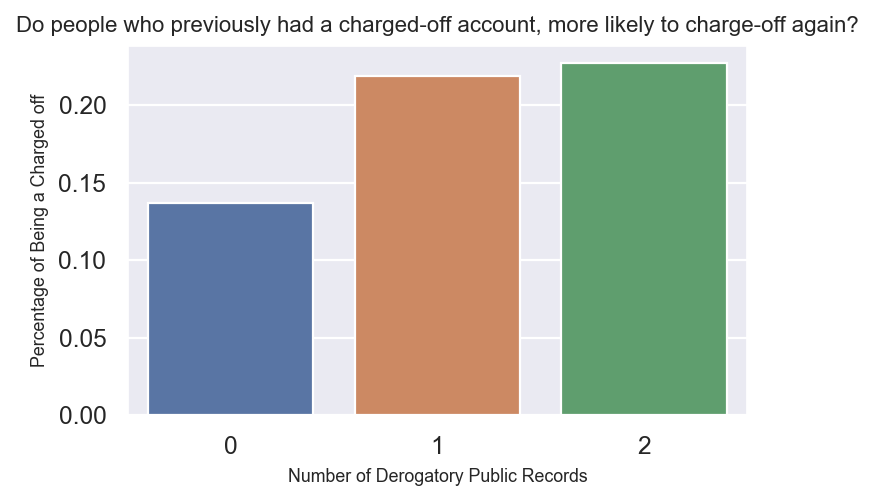

In [327]:
plt.figure(figsize=(5, 3), dpi=160)
sns.barplot(x=charge_off_rates_pub_rec.index, y=charge_off_rates_pub_rec.values)
plt.title("Do people who previously had a charged-off account, more likely to charge-off again?", fontsize=10)
plt.xlabel("Number of Derogatory Public Records", fontsize=8)
plt.ylabel("Percentage of Being a Charged off", fontsize=8)
plt.show()

That Confirms it.

# 5.21) revol_bal
##### Data Dictionary: "Total credit revolving balance."

In [328]:
loans["revol_bal"].describe()

count     35427.000000
mean      13356.302368
std       15670.341497
min           0.000000
25%        3771.500000
50%        8926.000000
75%       17051.000000
max      149588.000000
Name: revol_bal, dtype: float64

In [336]:
loans.groupby("loan_status")["revol_bal"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5003.0,13595.799520,14720.643899,0.0,4187.0,9487.0,17700.0,147365.0
Fully Paid,30424.0,13316.918847,15820.937992,0.0,3711.0,8833.0,16941.0,149588.0


There isn't a large difference in the means.

# 5.22) revol_util
##### Data Dictionary: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."

In [342]:
loans["revol_util"].describe()

count     35427
unique     1081
top          0%
freq        834
Name: revol_util, dtype: object

In [347]:
loans["revol_util"]

1         9.40%
3           21%
5        28.30%
6        85.60%
7        87.50%
          ...  
39551    96.50%
39562    68.70%
39623    62.90%
39666    34.30%
39680    70.90%
Name: revol_util, Length: 35427, dtype: object

Converting this feature to numeric

In [350]:
loans["revol_util"] = loans["revol_util"].apply(lambda x: float(x.replace("%", "")))

In [352]:
loans["revol_util"].describe()

count    35427.000000
mean        49.140047
std         28.227621
min          0.000000
25%         25.900000
50%         49.700000
75%         72.600000
max         99.900000
Name: revol_util, dtype: float64

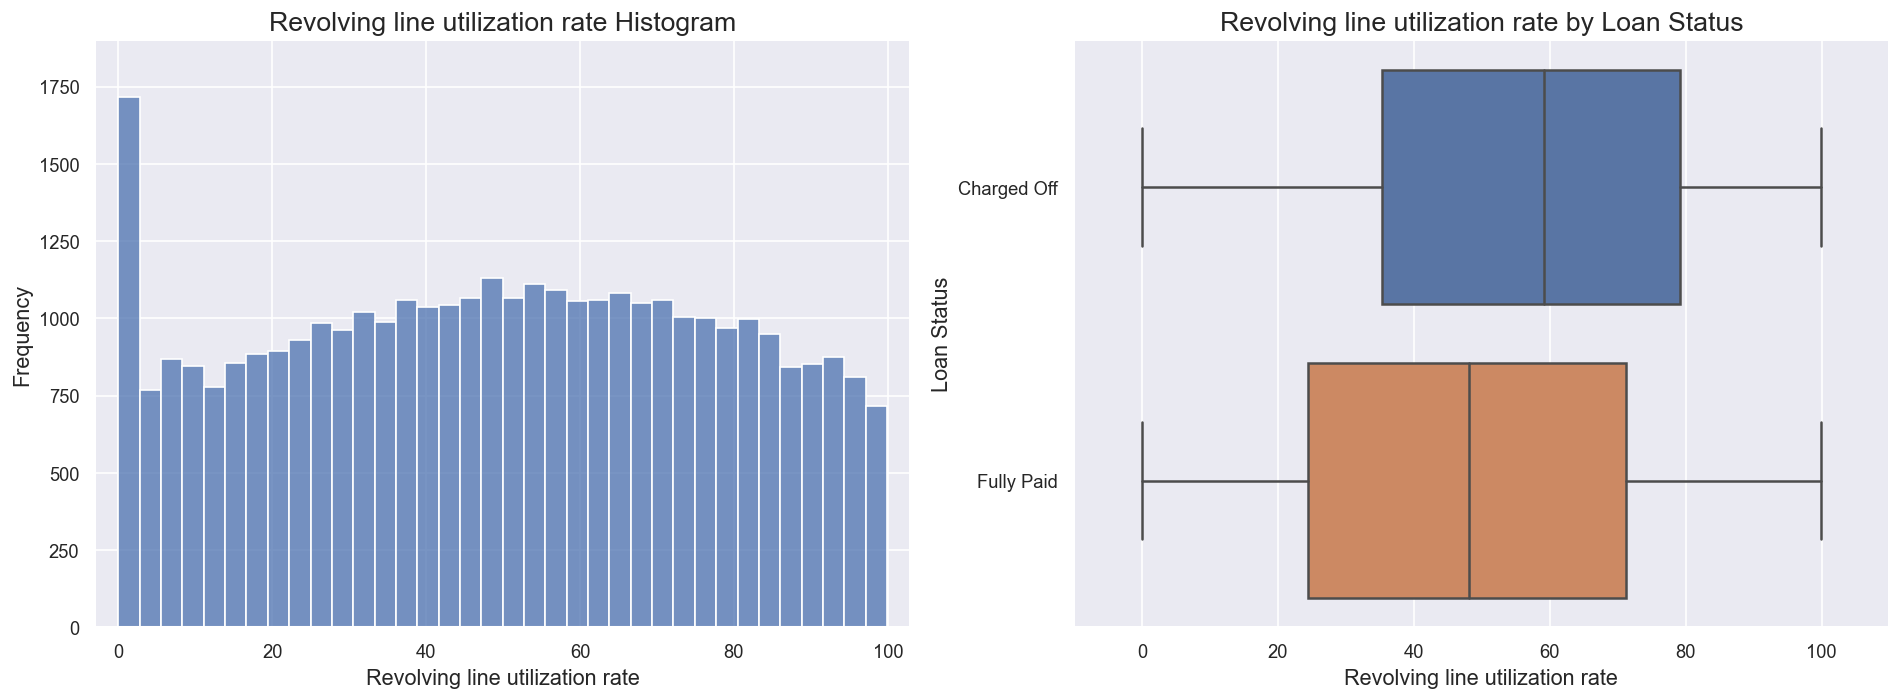

In [357]:
f2, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), dpi=120)
ax1.margins(0)
ax2.margins(0)

sns.histplot(x=loans["revol_util"], ax=ax1)
ax1.set_title("Revolving line utilization rate Histogram", fontsize=16)
ax1.set_xlabel("Revolving line utilization rate", fontsize=13)
ax1.set_ylabel("Frequency", fontsize=13)
ax1.set_xlim(min(loans["revol_util"]) - 3, max(loans["revol_util"]) + 3)
ax1.set_ylim(0, 1900)

sns.boxplot(y=loans["loan_status"], x=loans["revol_util"], ax=ax2)
ax2.set_title("Revolving line utilization rate by Loan Status", fontsize=16)
ax2.set_xlabel("Revolving line utilization rate", fontsize=13)
ax2.set_ylabel("Loan Status", fontsize=13)
ax2.set_xlim(min(loans["revol_util"]) - 10, max(loans["revol_util"]) + 10)

plt.tight_layout()
plt.show()

In [362]:
charge_off_rates_revol_util = loans.groupby(by="revol_util")["loan_status"].value_counts(normalize=True)[:, "Charged Off"]
revol_util_coeff, _ = pearsonr(charge_off_rates_revol_util.index, charge_off_rates_revol_util.values)

Seems like people with high amount of Revolving line utilization rate, are more likely to charge-off. Let's confirm that with a scatter plot

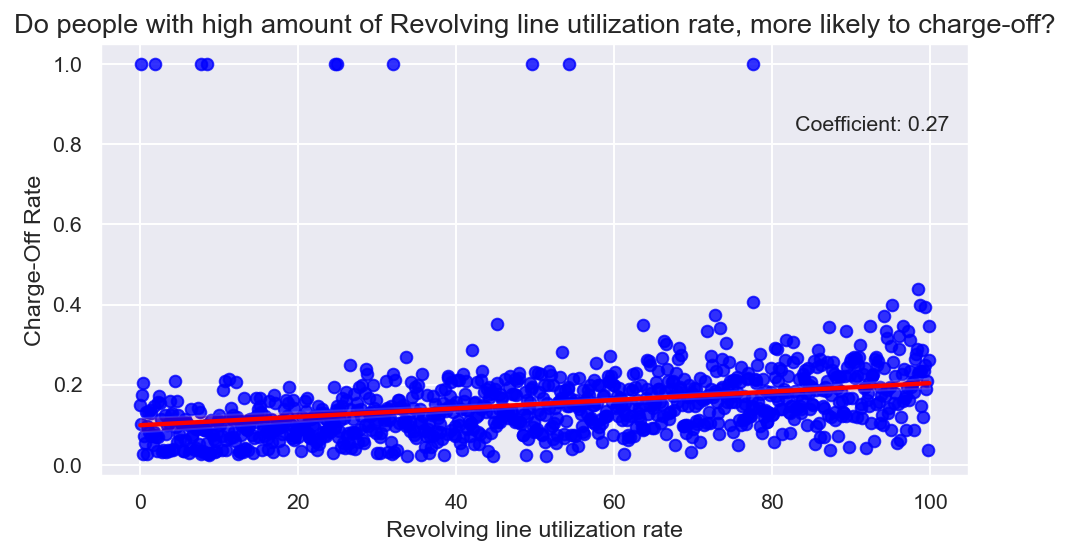

In [403]:
plt.figure(figsize=(8, 4), dpi=140)
sns.regplot(x=charge_off_rates_revol_util.index, y=charge_off_rates_revol_util.values, line_kws={"color": "red"}, scatter_kws={"color": "blue"})
plt.xlabel("Revolving line utilization rate", fontsize=12)
plt.ylabel("Charge-Off Rate", fontsize=12)
plt.title("Do people with high amount of Revolving line utilization rate, more likely to charge-off?", fontsize=14)
plt.text(0.8, 0.8, f"Coefficient: {revol_util_coeff:.2f}", transform=plt.gca().transAxes, fontsize=11)
plt.show()

That conforms it

# 5.23) total_acc
##### Data Dictionary: "The total number of credit lines currently in the borrower's credit file."

In [365]:
loans["total_acc"].describe()

count    35427.00000
mean        22.19869
std         11.40354
min          2.00000
25%         14.00000
50%         21.00000
75%         29.00000
max         90.00000
Name: total_acc, dtype: float64

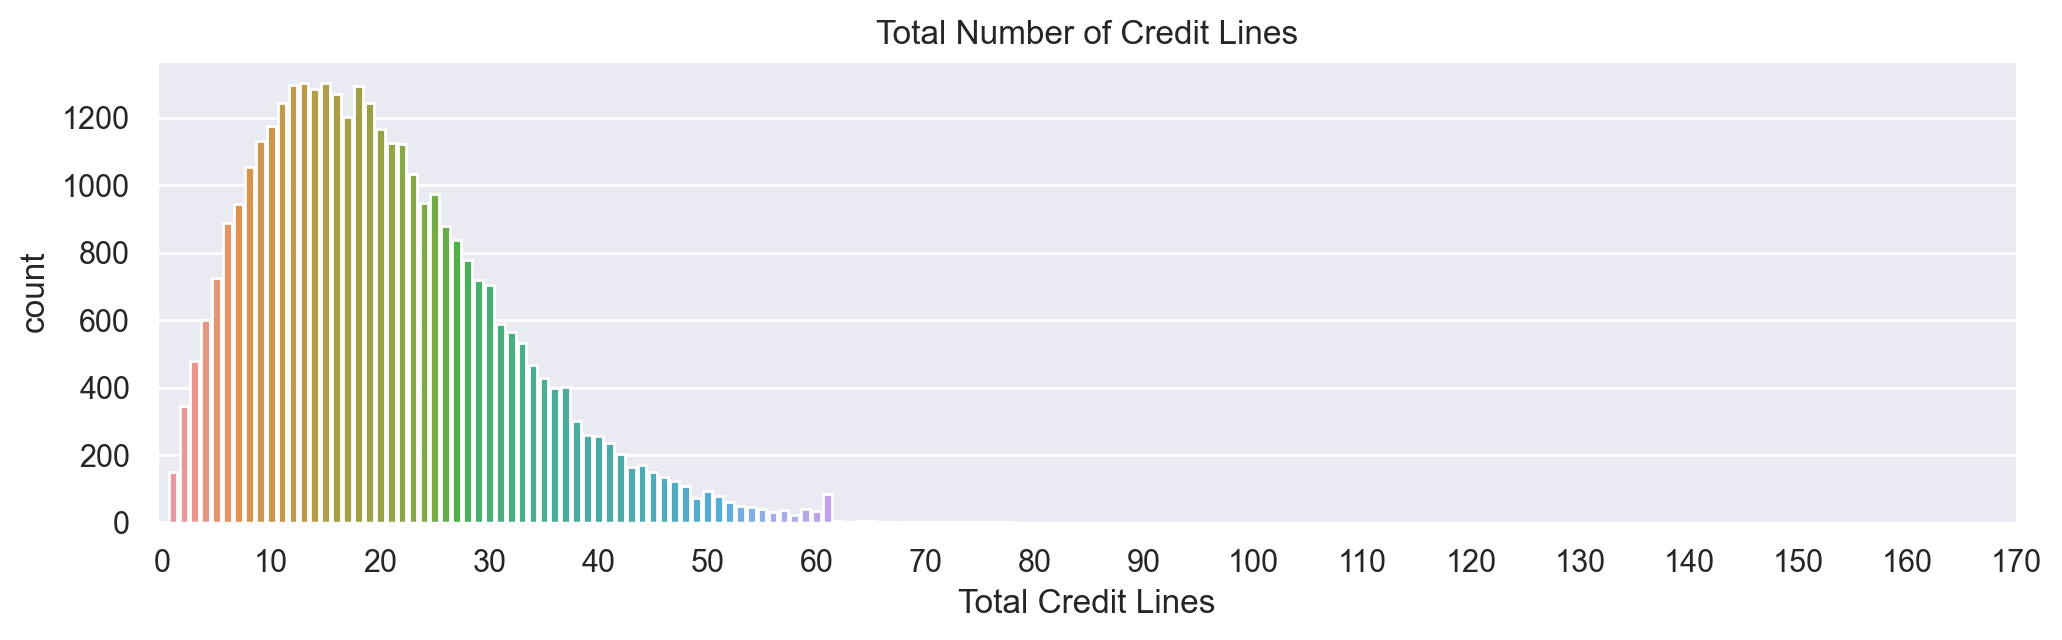

In [378]:
plt.figure(figsize=(12,3), dpi=200)
sns.countplot(x=loans['total_acc'])
_, _ = plt.xticks(np.arange(0, 176, 10), np.arange(0, 176, 10))
plt.title('Total Number of Credit Lines')
plt.xlabel("Total Credit Lines")
plt.show()

In [379]:
loans.groupby('loan_status')['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5003.0,21.661403,11.438013,2.0,13.0,20.0,29.0,70.0
Fully Paid,30424.0,22.287043,11.395624,3.0,14.0,21.0,29.0,90.0


No large differences here.

# 5.24) initial_list_status
##### Data Dictionary: "The initial listing status of the loan. Possible values are – W, F".

In [380]:
loans["initial_list_status"].value_counts()

initial_list_status
f    35427
Name: count, dtype: int64

as this has only one value this feature has no use to us.

In [381]:
loans.drop(labels="initial_list_status", axis=1, inplace=True)

# 5.25) application_type
##### Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

In [382]:
loans["application_type"].value_counts()

application_type
INDIVIDUAL    35427
Name: count, dtype: int64

This column too does not give any useful insights. Hence let's drop this feature too

In [383]:
loans.drop(labels="application_type", axis=1, inplace=True)

# 5.26) pub_rec_bankruptcies
##### Data Dictionary: "Number of public record bankruptcies."

In [384]:
loans["pub_rec_bankruptcies"].value_counts()

pub_rec_bankruptcies
0.0    33952
1.0     1470
2.0        5
Name: count, dtype: int64

Charge off rate by Bankruptcy

In [385]:
charge_off_rates_bankruptcies = loans.groupby("pub_rec_bankruptcies")["loan_status"].value_counts(normalize=True)[:, "Charged Off"]

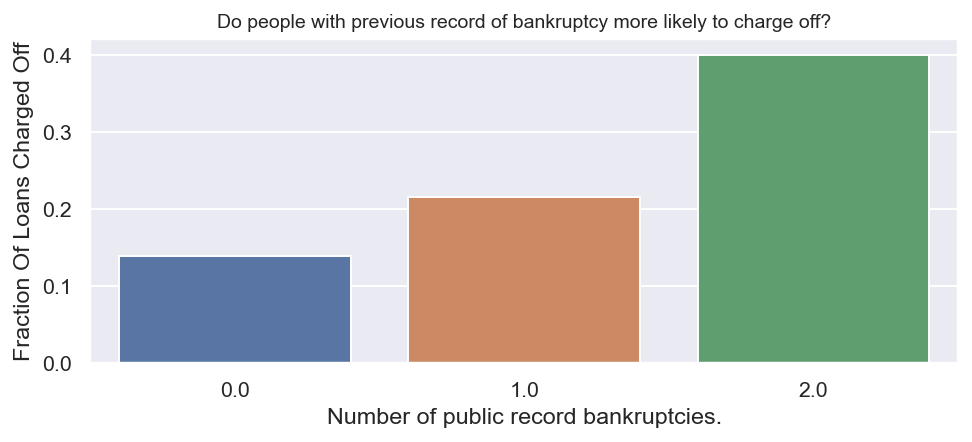

In [388]:
plt.figure(figsize=(8, 3), dpi=140)
sns.barplot(x=charge_off_rates_bankruptcies.index, y=charge_off_rates_bankruptcies.values)
plt.xlabel("Number of public record bankruptcies.", fontsize=12)
plt.ylabel("Fraction Of Loans Charged Off", fontsize=12)
plt.title("Do people with previous record of bankruptcy more likely to charge off?", fontsize=10)
plt.show()

# 6. Conclusion

How many driver variables do we have?

In [389]:
loans.shape

(35427, 20)

Let's see all the Driving features

In [390]:
loans.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'addr_state', 'dti', 'earliest_cr_line',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'pub_rec_bankruptcies'],
      dtype='object')